# S&P 500 Regression

## Code References

Please note that the majority of the code used in this project was learned through official documentation. There are specific sections that were written with the help of other sources and these have been mentioned. They are also referenced under 'Code References' in the associated paper.

## Section One: Import Libraries

In [1]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sci
import numpy as np
from sklearn import preprocessing
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
import math
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)

## Section Two: Load Data Into Pandas

The S&P 500 index has various sector weightings that can change over time. Therefore, instead of gathering economic data that are sector specific, variables that, together, will most likely provide us with a good microeconomic overview of the US economy have been chosen. For this study specifically, finding indicators that give us insights into the state of consumers, industry (with a focus on production and the overall supply chain) and the general economy was the main aim. 

The gathering process only involved using highly reputable sources that specialise in economic research. As a result, it was extremely difficult to find reliable raw monthly US GDP estimates, thus, the normalised monthly GDP produced by the OECD was used as the next best alternative. CPI was also used to hopefully find a correlation between inflation and the US stock markets.

This project looks at the Industrial Production Index, New Manufacturing Orders and the Business Tendency Survey (manufacturing) to hopefully gain some insights into the overall state of the production and supply chain of the US economy and plug any relationships with the target into the models.

Unemployment rate, Michigan Consumer Sentiment Index and Total Nonfarm Payrolls have been chosen with the assumption that there should be a relationship between consumer sentiment and employment figures with the US stock markets.

The time period for this study was chosen to make sure that the data is highly relevant to modern retail investors (who now have access to far superior electronic trading capabilities) and aligns with the recent rise in popularity of index funds.

In [2]:
# Load all data...

sp500 = pd.read_csv('./Data/S&P 500 Index.csv') # S&P 500.

indusProd = pd.read_csv('./Data/US Industrial Prod Index Adjusted.csv') # Industrial Production Index.

cpi = pd.read_csv('./Data/US CPI Monthly Unadjusted.csv') # CPI.

consSent = pd.read_csv('./Data/US Michigan Consumer Sentiment Index.csv') # Michigan Consumer Sentiment Index.

nonFarm = pd.read_csv('./Data/US Total Nonfarm Adjusted.csv') # Total Nonfarm Payrolls.

unempRate = pd.read_csv('./Data/US Unemployment Rate Adjusted.csv') # Unemployment Rate.

gdp = pd.read_csv('./Data/US GDP Monthly Normalised.csv') # GDP.

manufNewOrd = pd.read_csv('./Data/US Manufacturers New Orders Durable Goods Adjusted.csv') # Manufacturer's New Orders.

busTendSurv = pd.read_csv('./Data/OECD US Business Tendency Surveys Manufacturing Adjusted.csv') # Business Tendency Survey.

## Section Three: Data Wrangling

### S&P 500 Data

Note! Despite the 'Date' column being labelled as the first day of each month, the closing value is actually for the last day of each month. This is better for our purposes because no matter what day in the associated month our feature values were released in, we know that there will at least be a month lag between them and the target in our final dataset.

In [3]:
sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-01,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-01,17.760000,17.760000,17.260000,17.570000,17.570000,0
2,1928-02-01,17.530001,17.629999,16.950001,17.260000,17.260000,0
3,1928-03-01,17.299999,19.280001,17.299999,19.280001,19.280001,0
4,1928-04-01,18.910000,19.750000,18.910000,19.750000,19.750000,0


In [4]:
# No missing values.
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116 entries, 0 to 1115
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1116 non-null   object 
 1   Open       1116 non-null   float64
 2   High       1116 non-null   float64
 3   Low        1116 non-null   float64
 4   Close      1116 non-null   float64
 5   Adj Close  1116 non-null   float64
 6   Volume     1116 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 61.2+ KB


The 'Date' column needs to be changed to be of datetime type so that the observations can be filtered to the specific time period needed for this study.

In [5]:
sp500.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [6]:
sp500['Date'] = pd.to_datetime(sp500['Date'])

sp500.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

We need to sort the S&P 500 data in ascending order from the last month of 1999. We filter from December 1999 to use the lagged feature variables, High, Low and Volume.

In [7]:
sp500 = sp500[sp500.Date >= datetime.datetime(1999, 12, 1, 0, 0, 0, 0)]

sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
864,1999-12-01,1388.910034,1473.099976,1387.380005,1469.250000,1469.250000,19640690000
865,2000-01-01,1469.250000,1478.000000,1350.140015,1394.459961,1394.459961,21494400000
866,2000-02-01,1394.459961,1444.550049,1325.069946,1366.420044,1366.420044,20912000000
867,2000-03-01,1366.420044,1552.869995,1346.619995,1498.579956,1498.579956,26156200000
868,2000-04-01,1498.579956,1527.189941,1339.400024,1452.430054,1452.430054,20106460000


In [8]:
sp500.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1111,2020-07-01,3105.919922,3279.989990,3101.169922,3271.120117,3271.120117,97197020000
1112,2020-08-01,3288.260010,3514.770020,3284.530029,3500.310059,3500.310059,84402300000
1113,2020-09-01,3507.439941,3588.110107,3209.449951,3363.000000,3363.000000,92084120000
1114,2020-10-01,3385.870117,3549.850098,3323.689941,3465.389893,3465.389893,66929150000
1115,2020-10-23,3464.899902,3466.459961,3440.449951,3465.389893,3465.389893,2161970435


The 'Open' and 'Adj Close' columns are deleted as they will not be used for this project. The target will be the 'Close' column, and the three technical variables that will be used for this study are the 'High', 'Low' and 'Volume'.

In [9]:
del sp500['Open']
del sp500['Adj Close']

# 'Close' is the target.
sp500 = sp500[['Date', 'Close', 'High', 'Low', 'Volume']]

sp500.head()

,Date,Close,High,Low,Volume
864,1999-12-01,1469.250000,1473.099976,1387.380005,19640690000
865,2000-01-01,1394.459961,1478.000000,1350.140015,21494400000
866,2000-02-01,1366.420044,1444.550049,1325.069946,20912000000
867,2000-03-01,1498.579956,1552.869995,1346.619995,26156200000
868,2000-04-01,1452.430054,1527.189941,1339.400024,20106460000


### Industrial Production Index Data

In [10]:
indusProd['DATE'] = pd.to_datetime(indusProd['DATE'])

indusProd.dtypes

DATE      datetime64[ns]
INDPRO           float64
dtype: object

In [11]:
indusProd = indusProd[indusProd.DATE >= datetime.datetime(1999, 12, 1, 0, 0, 0, 0)]

# Note how the date periods are in exactly the same format as the S&P 500.
indusProd.head()

,DATE,INDPRO
971,1999-12-01,94.1593
972,2000-01-01,94.1758
973,2000-02-01,94.4557
974,2000-03-01,94.7980
975,2000-04-01,95.4808


Notice below how indusProd goes up to September 2020, but S&P 500 goes up to October 2020. We need to account for this at the end of the data wrangling process with the final data frame.

In [12]:
indusProd.tail()

,DATE,INDPRO
1216,2020-05-01,91.9327
1217,2020-06-01,97.6071
1218,2020-07-01,101.6989
1219,2020-08-01,102.1509
1220,2020-09-01,101.5055


In [13]:
indusProd.reset_index(drop=True, inplace=True)

indusProd['IndusProd'] = indusProd['INDPRO']

del indusProd['DATE']
del indusProd['INDPRO']

indusProd

,IndusProd
0,94.1593
1,94.1758
2,94.4557
3,94.7980
4,95.4808
...,...
245,91.9327
246,97.6071
247,101.6989
248,102.1509


In [14]:
data = sp500
data.reset_index(drop=True, inplace=True)

data['IndusProd'] = indusProd['IndusProd']

data.head()

,Date,Close,High,Low,Volume,IndusProd
0,1999-12-01,1469.250000,1473.099976,1387.380005,19640690000,94.1593
1,2000-01-01,1394.459961,1478.000000,1350.140015,21494400000,94.1758
2,2000-02-01,1366.420044,1444.550049,1325.069946,20912000000,94.4557
3,2000-03-01,1498.579956,1552.869995,1346.619995,26156200000,94.7980
4,2000-04-01,1452.430054,1527.189941,1339.400024,20106460000,95.4808


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Close      252 non-null    float64       
 2   High       252 non-null    float64       
 3   Low        252 non-null    float64       
 4   Volume     252 non-null    int64         
 5   IndusProd  250 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 11.9 KB


### Consumer Price Index Data

In [16]:
# Notice the same date format as S&P 500.
cpi.head()

,DATE,CPALTT01USM657N_NBD19600201
0,1960-01-01,-99.65986
1,1960-02-01,100.00000
2,1960-03-01,0.00000
3,1960-04-01,99.65986
4,1960-05-01,0.00000


In [17]:
# Again, we have the date ending problem, we will handle this later...
cpi.tail()

,DATE,CPALTT01USM657N_NBD19600201
723,2020-04-01,-195.92740
724,2020-05-01,0.57140
725,2020-06-01,160.33097
726,2020-07-01,148.20653
727,2020-08-01,92.38907


In [18]:
cpi['DATE'] = pd.to_datetime(cpi['DATE'])

cpi.dtypes

DATE                           datetime64[ns]
CPALTT01USM657N_NBD19600201           float64
dtype: object

In [19]:
cpi = cpi[cpi.DATE >= datetime.datetime(1999, 12, 1, 0, 0, 0, 0)]
cpi.reset_index(drop=True, inplace=True)
cpi = cpi.rename(columns={'CPALTT01USM657N_NBD19600201': 'CPI'})

cpi.head()

,DATE,CPI
0,1999-12-01,0.00000
1,2000-01-01,87.04694
2,2000-02-01,173.57820
3,2000-03-01,241.57833
4,2000-04-01,17.11449


In [20]:
data['CPI'] = cpi['CPI']

data.tail()

,Date,Close,High,Low,Volume,IndusProd,CPI
247,2020-07-01,3271.120117,3279.989990,3101.169922,97197020000,101.6989,148.20653
248,2020-08-01,3500.310059,3514.770020,3284.530029,84402300000,102.1509,92.38907
249,2020-09-01,3363.000000,3588.110107,3209.449951,92084120000,101.5055,NaN
250,2020-10-01,3465.389893,3549.850098,3323.689941,66929150000,NaN,NaN
251,2020-10-23,3465.389893,3466.459961,3440.449951,2161970435,NaN,NaN


In [21]:
data.head()

,Date,Close,High,Low,Volume,IndusProd,CPI
0,1999-12-01,1469.250000,1473.099976,1387.380005,19640690000,94.1593,0.00000
1,2000-01-01,1394.459961,1478.000000,1350.140015,21494400000,94.1758,87.04694
2,2000-02-01,1366.420044,1444.550049,1325.069946,20912000000,94.4557,173.57820
3,2000-03-01,1498.579956,1552.869995,1346.619995,26156200000,94.7980,241.57833
4,2000-04-01,1452.430054,1527.189941,1339.400024,20106460000,95.4808,17.11449


### University Of Michigan Consumer Sentiment Index Data

In [22]:
consSent.head(12)

,Month,Year,Index
0,1,1999,103.9
1,2,1999,108.1
2,3,1999,105.7
3,4,1999,104.6
4,5,1999,106.8
5,6,1999,107.3
6,7,1999,106.0
7,8,1999,104.5
8,9,1999,107.2
9,10,1999,103.2


The University of Michigan releases a preliminary on the second Friday of each month and a revised version on the fourth Friday of each month at 10:00 a.m, whilst all the other variables are based on the first day of each month.

In [23]:
for index, row in consSent.iterrows():
        # Note! We set 28 as the day for all rows. The reason for this is because we already know that the latest data 
        # is released on the fourth Friday of each month. So as long as we get the correct month, the actual day is 
        # irrelevant.
        consSent.loc[index, 'Date'] = datetime.date(consSent.loc[index, 'Year'], consSent.loc[index, 'Month'], 28)
        
consSent.head()

,Month,Year,Index,Date
0,1,1999,103.9,1999-01-28
1,2,1999,108.1,1999-02-28
2,3,1999,105.7,1999-03-28
3,4,1999,104.6,1999-04-28
4,5,1999,106.8,1999-05-28


In [24]:
del consSent['Month']
del consSent['Year']

consSent.head(12)

,Index,Date
0,103.9,1999-01-28
1,108.1,1999-02-28
2,105.7,1999-03-28
3,104.6,1999-04-28
4,106.8,1999-05-28
5,107.3,1999-06-28
6,106.0,1999-07-28
7,104.5,1999-08-28
8,107.2,1999-09-28
9,103.2,1999-10-28


In [25]:
consSent = consSent[consSent.Date >= datetime.date(1999, 12, 28)]

consSent.head()

,Index,Date
11,105.4,1999-12-28
12,112.0,2000-01-28
13,111.3,2000-02-28
14,107.1,2000-03-28
15,109.2,2000-04-28


In [26]:
consSent.reset_index(drop=True, inplace=True)

consSent.head()

,Index,Date
0,105.4,1999-12-28
1,112.0,2000-01-28
2,111.3,2000-02-28
3,107.1,2000-03-28
4,109.2,2000-04-28


In [27]:
data['ConsSentIdx'] = consSent['Index']

# Notice how the ConsSentIdx months align appropriately with the target date now, i.e. a few days before.
data.head()

,Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx
0,1999-12-01,1469.250000,1473.099976,1387.380005,19640690000,94.1593,0.00000,105.4
1,2000-01-01,1394.459961,1478.000000,1350.140015,21494400000,94.1758,87.04694,112.0
2,2000-02-01,1366.420044,1444.550049,1325.069946,20912000000,94.4557,173.57820,111.3
3,2000-03-01,1498.579956,1552.869995,1346.619995,26156200000,94.7980,241.57833,107.1
4,2000-04-01,1452.430054,1527.189941,1339.400024,20106460000,95.4808,17.11449,109.2


### Total Nonfarm Payrolls Data

In [28]:
nonFarm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    981 non-null    object
 1   PAYEMS  981 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.5+ KB


In [29]:
nonFarm.head()

,DATE,PAYEMS
0,1939-01-01,29923
1,1939-02-01,30100
2,1939-03-01,30280
3,1939-04-01,30094
4,1939-05-01,30299


Notice how there is a huge difference in the total nonfarm payrolls figure between time periods. This could be a significant limitation of the data as our linear regression models may have to be refitted continuously as the overall figures change.

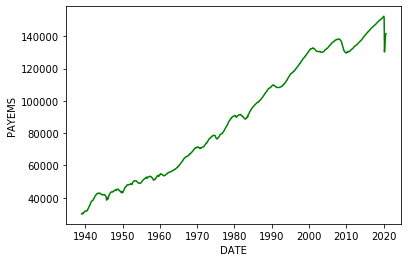

In [30]:
nonFarm['DATE'] = pd.to_datetime(nonFarm['DATE'])

sb.lineplot(data=nonFarm, x='DATE', y='PAYEMS', color='green')

In [31]:
nonFarm = nonFarm[nonFarm.DATE >= datetime.datetime(1999, 12, 1)]
nonFarm.reset_index(drop=True, inplace=True)

nonFarm.head()

,DATE,PAYEMS
0,1999-12-01,130772
1,2000-01-01,131005
2,2000-02-01,131124
3,2000-03-01,131596
4,2000-04-01,131888


In [32]:
data['NonFarm'] = nonFarm['PAYEMS']

data.head()

,Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm
0,1999-12-01,1469.250000,1473.099976,1387.380005,19640690000,94.1593,0.00000,105.4,130772.0
1,2000-01-01,1394.459961,1478.000000,1350.140015,21494400000,94.1758,87.04694,112.0,131005.0
2,2000-02-01,1366.420044,1444.550049,1325.069946,20912000000,94.4557,173.57820,111.3,131124.0
3,2000-03-01,1498.579956,1552.869995,1346.619995,26156200000,94.7980,241.57833,107.1,131596.0
4,2000-04-01,1452.430054,1527.189941,1339.400024,20106460000,95.4808,17.11449,109.2,131888.0


### Unemployment Rate Data

In [33]:
unempRate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    873 non-null    object 
 1   UNRATE  873 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.8+ KB


In [34]:
unempRate.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


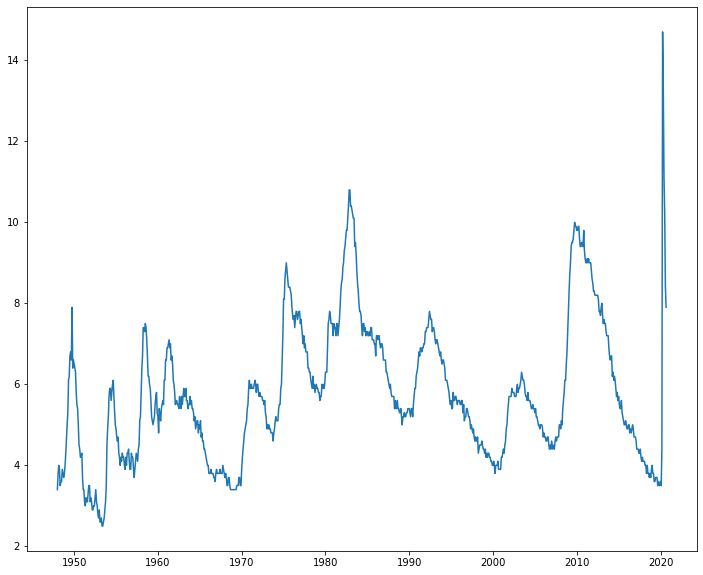

In [35]:
unempRate['DATE'] = pd.to_datetime(unempRate['DATE'])

fig = plt.figure(figsize=(12,10))

plt.plot(unempRate['DATE'], unempRate['UNRATE'])
plt.savefig('UnempRateLinePlot.png')

In [36]:
unempRate = unempRate[unempRate.DATE >= datetime.datetime(1999, 12, 1)]
unempRate.reset_index(drop=True, inplace=True)

unempRate.head()

,DATE,UNRATE
0,1999-12-01,4.0
1,2000-01-01,4.0
2,2000-02-01,4.1
3,2000-03-01,4.0
4,2000-04-01,3.8


In [37]:
unempRate.tail()

,DATE,UNRATE
245,2020-05-01,13.3
246,2020-06-01,11.1
247,2020-07-01,10.2
248,2020-08-01,8.4
249,2020-09-01,7.9


In [38]:
data['UnempRate'] = unempRate['UNRATE']

data.head()

,Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate
0,1999-12-01,1469.250000,1473.099976,1387.380005,19640690000,94.1593,0.00000,105.4,130772.0,4.0
1,2000-01-01,1394.459961,1478.000000,1350.140015,21494400000,94.1758,87.04694,112.0,131005.0,4.0
2,2000-02-01,1366.420044,1444.550049,1325.069946,20912000000,94.4557,173.57820,111.3,131124.0,4.1
3,2000-03-01,1498.579956,1552.869995,1346.619995,26156200000,94.7980,241.57833,107.1,131596.0,4.0
4,2000-04-01,1452.430054,1527.189941,1339.400024,20106460000,95.4808,17.11449,109.2,131888.0,3.8


### GDP Data

In [39]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              725 non-null    object 
 1   USALORSGPNOSTSAM  725 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.5+ KB


In [40]:
gdp.head()

,DATE,USALORSGPNOSTSAM
0,1960-01-01,100.991753
1,1960-02-01,101.002091
2,1960-03-01,100.925908
3,1960-04-01,100.765534
4,1960-05-01,100.539971


In [41]:
gdp = gdp.rename(columns={'USALORSGPNOSTSAM': 'GDP'})

gdp.head()

,DATE,GDP
0,1960-01-01,100.991753
1,1960-02-01,101.002091
2,1960-03-01,100.925908
3,1960-04-01,100.765534
4,1960-05-01,100.539971


In [42]:
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp = gdp[gdp.DATE >= datetime.datetime(1999, 12, 1)]
gdp.reset_index(drop=True, inplace=True)

gdp.head()

,DATE,GDP
0,1999-12-01,101.392898
1,2000-01-01,101.451927
2,2000-02-01,101.516102
3,2000-03-01,101.593821
4,2000-04-01,101.668810


In [43]:
data['GDP'] = gdp['GDP']

data.head()

,Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP
0,1999-12-01,1469.250000,1473.099976,1387.380005,19640690000,94.1593,0.00000,105.4,130772.0,4.0,101.392898
1,2000-01-01,1394.459961,1478.000000,1350.140015,21494400000,94.1758,87.04694,112.0,131005.0,4.0,101.451927
2,2000-02-01,1366.420044,1444.550049,1325.069946,20912000000,94.4557,173.57820,111.3,131124.0,4.1,101.516102
3,2000-03-01,1498.579956,1552.869995,1346.619995,26156200000,94.7980,241.57833,107.1,131596.0,4.0,101.593821
4,2000-04-01,1452.430054,1527.189941,1339.400024,20106460000,95.4808,17.11449,109.2,131888.0,3.8,101.668810


### Manufacturer's New Orders Data

In [44]:
manufNewOrd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     344 non-null    object 
 1   DGORDER  344 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.5+ KB


In [45]:
manufNewOrd.head()

,DATE,DGORDER
0,1992-02-01,114535.0
1,1992-03-01,120025.0
2,1992-04-01,124470.0
3,1992-05-01,125822.0
4,1992-06-01,122834.0


In [46]:
manufNewOrd['DATE'] = pd.to_datetime(manufNewOrd['DATE'])
manufNewOrd = manufNewOrd[manufNewOrd.DATE >= datetime.datetime(1999, 12, 1)]
manufNewOrd.reset_index(drop=True, inplace=True)
manufNewOrd = manufNewOrd.rename(columns={'DGORDER': 'ManufNewOrd'})

manufNewOrd.head()

,DATE,ManufNewOrd
0,1999-12-01,196344.0
1,2000-01-01,201360.0
2,2000-02-01,183911.0
3,2000-03-01,192130.0
4,2000-04-01,195044.0


In [47]:
data['ManufNewOrd'] = manufNewOrd['ManufNewOrd']

data.head()

,Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP,ManufNewOrd
0,1999-12-01,1469.250000,1473.099976,1387.380005,19640690000,94.1593,0.00000,105.4,130772.0,4.0,101.392898,196344.0
1,2000-01-01,1394.459961,1478.000000,1350.140015,21494400000,94.1758,87.04694,112.0,131005.0,4.0,101.451927,201360.0
2,2000-02-01,1366.420044,1444.550049,1325.069946,20912000000,94.4557,173.57820,111.3,131124.0,4.1,101.516102,183911.0
3,2000-03-01,1498.579956,1552.869995,1346.619995,26156200000,94.7980,241.57833,107.1,131596.0,4.0,101.593821,192130.0
4,2000-04-01,1452.430054,1527.189941,1339.400024,20106460000,95.4808,17.11449,109.2,131888.0,3.8,101.668810,195044.0


### OECD Business Tendency Survey Data

In [48]:
busTendSurv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DATE                         729 non-null    object 
 1   BSCICP03USM665S_NBD19600101  729 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.5+ KB


In [49]:
busTendSurv.head()

,DATE,BSCICP03USM665S_NBD19600101
0,1960-01-01,100.00000
1,1960-02-01,99.25722
2,1960-03-01,98.29266
3,1960-04-01,97.53680
4,1960-05-01,97.13006


In [50]:
busTendSurv['DATE'] = pd.to_datetime(busTendSurv['DATE'])
busTendSurv = busTendSurv[busTendSurv.DATE >= datetime.datetime(1999, 12, 1)]
busTendSurv.reset_index(drop=True, inplace=True)
busTendSurv = busTendSurv.rename(columns={'BSCICP03USM665S_NBD19600101': 'BusTendSurvManuf'})

busTendSurv.head()

,DATE,BusTendSurvManuf
0,1999-12-01,100.16403
1,2000-01-01,100.00806
2,2000-02-01,99.81309
3,2000-03-01,99.62009
4,2000-04-01,99.43039


In [51]:
data['BusTendSurvManuf'] = busTendSurv['BusTendSurvManuf']

### Final Dataset

In [52]:
data = data.rename(columns={'Date': 'SP500 Date'})
data_original = data # For later use if need be.

data.head()

,SP500 Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP,ManufNewOrd,BusTendSurvManuf
0,1999-12-01,1469.250000,1473.099976,1387.380005,19640690000,94.1593,0.00000,105.4,130772.0,4.0,101.392898,196344.0,100.16403
1,2000-01-01,1394.459961,1478.000000,1350.140015,21494400000,94.1758,87.04694,112.0,131005.0,4.0,101.451927,201360.0,100.00806
2,2000-02-01,1366.420044,1444.550049,1325.069946,20912000000,94.4557,173.57820,111.3,131124.0,4.1,101.516102,183911.0,99.81309
3,2000-03-01,1498.579956,1552.869995,1346.619995,26156200000,94.7980,241.57833,107.1,131596.0,4.0,101.593821,192130.0,99.62009
4,2000-04-01,1452.430054,1527.189941,1339.400024,20106460000,95.4808,17.11449,109.2,131888.0,3.8,101.668810,195044.0,99.43039


We now need to shift down the feature variables by one row, so that each row will have feature values that are associated with the month before the target.

In [53]:
data['High'] = data['High'].shift(1)
data['Low'] = data['Low'].shift(1)
data['Volume'] = data['Volume'].shift(1)
data['IndusProd'] = data['IndusProd'].shift(1)
data['CPI'] = data['CPI'].shift(1)
data['ConsSentIdx'] = data['ConsSentIdx'].shift(1)
data['NonFarm'] = data['NonFarm'].shift(1)
data['UnempRate'] = data['UnempRate'].shift(1)
data['GDP'] = data['GDP'].shift(1)
data['ManufNewOrd'] = data['ManufNewOrd'].shift(1)
data['BusTendSurvManuf'] = data['BusTendSurvManuf'].shift(1)

data.head()

,SP500 Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP,ManufNewOrd,BusTendSurvManuf
0,1999-12-01,1469.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-01,1394.459961,1473.099976,1387.380005,1.964069e+10,94.1593,0.00000,105.4,130772.0,4.0,101.392898,196344.0,100.16403
2,2000-02-01,1366.420044,1478.000000,1350.140015,2.149440e+10,94.1758,87.04694,112.0,131005.0,4.0,101.451927,201360.0,100.00806
3,2000-03-01,1498.579956,1444.550049,1325.069946,2.091200e+10,94.4557,173.57820,111.3,131124.0,4.1,101.516102,183911.0,99.81309
4,2000-04-01,1452.430054,1552.869995,1346.619995,2.615620e+10,94.7980,241.57833,107.1,131596.0,4.0,101.593821,192130.0,99.62009


In [54]:
data = data.iloc[1:]

data.head()

,SP500 Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP,ManufNewOrd,BusTendSurvManuf
1,2000-01-01,1394.459961,1473.099976,1387.380005,1.964069e+10,94.1593,0.00000,105.4,130772.0,4.0,101.392898,196344.0,100.16403
2,2000-02-01,1366.420044,1478.000000,1350.140015,2.149440e+10,94.1758,87.04694,112.0,131005.0,4.0,101.451927,201360.0,100.00806
3,2000-03-01,1498.579956,1444.550049,1325.069946,2.091200e+10,94.4557,173.57820,111.3,131124.0,4.1,101.516102,183911.0,99.81309
4,2000-04-01,1452.430054,1552.869995,1346.619995,2.615620e+10,94.7980,241.57833,107.1,131596.0,4.0,101.593821,192130.0,99.62009
5,2000-05-01,1420.599976,1527.189941,1339.400024,2.010646e+10,95.4808,17.11449,109.2,131888.0,3.8,101.668810,195044.0,99.43039


In [55]:
data.tail(20)

,SP500 Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP,ManufNewOrd,BusTendSurvManuf
232,2019-04-01,2945.830078,2860.310059,2722.270020,7.859628e+10,109.6811,165.29180,98.4,150282.0,3.8,100.023603,252004.0,99.43413
233,2019-05-01,2752.060059,2949.520020,2848.629883,6.960484e+10,108.9888,155.14355,97.2,150492.0,3.6,99.993925,240268.0,99.21424
234,2019-06-01,2941.760010,2954.129883,2750.520020,7.686012e+10,109.2264,62.37263,100.0,150577.0,3.6,99.966458,236720.0,99.01227
235,2019-07-01,2980.379883,2964.149902,2728.810059,7.088139e+10,109.2774,5.83501,98.2,150759.0,3.7,99.945137,236884.0,98.83025
236,2019-08-01,2926.459961,3027.979980,2952.219971,7.034947e+10,109.0852,48.95859,98.4,150953.0,3.7,99.930497,242842.0,98.61232
237,2019-09-01,2976.739990,3013.590088,2822.120117,7.959944e+10,109.8543,-1.48458,89.8,151160.0,3.7,99.921600,244018.0,98.33827
238,2019-10-01,3037.560059,3021.989990,2891.850098,7.399233e+10,109.4725,22.95504,93.2,151368.0,3.5,99.917453,241713.0,98.13076
239,2019-11-01,3140.979980,3050.100098,2855.939941,7.756455e+10,109.0270,66.98538,95.5,151553.0,3.6,99.917978,241557.0,98.06452
240,2019-12-01,3230.780029,3154.260010,3050.719971,7.217992e+10,110.0388,-15.71192,96.8,151814.0,3.5,99.923681,235237.0,98.08613
241,2020-01-01,3225.520020,3247.929932,3070.330078,7.205400e+10,109.6527,-26.65625,99.3,151998.0,3.5,99.934954,241852.0,98.19094


With the exception of the S&P 500 variables, all predictor variables do not have as many observations as the target variable. As the difference in observations is small, rather than trying to fill in these NaNs with uncertain values, the last 5 rows will simply be removed.

In [56]:
data = data.iloc[:-5]

data.tail(10)

,SP500 Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP,ManufNewOrd,BusTendSurvManuf
237,2019-09-01,2976.739990,3013.590088,2822.120117,7.959944e+10,109.8543,-1.48458,89.8,151160.0,3.7,99.921600,244018.0,98.33827
238,2019-10-01,3037.560059,3021.989990,2891.850098,7.399233e+10,109.4725,22.95504,93.2,151368.0,3.5,99.917453,241713.0,98.13076
239,2019-11-01,3140.979980,3050.100098,2855.939941,7.756455e+10,109.0270,66.98538,95.5,151553.0,3.6,99.917978,241557.0,98.06452
240,2019-12-01,3230.780029,3154.260010,3050.719971,7.217992e+10,110.0388,-15.71192,96.8,151814.0,3.5,99.923681,235237.0,98.08613
241,2020-01-01,3225.520020,3247.929932,3070.330078,7.205400e+10,109.6527,-26.65625,99.3,151998.0,3.5,99.934954,241852.0,98.19094
242,2020-02-01,2954.219971,3337.770020,3214.639893,7.710442e+10,109.1845,113.67726,99.8,152212.0,3.6,99.950979,241417.0,98.35717
243,2020-03-01,2584.590088,3393.520020,2855.840088,8.429227e+10,109.2966,80.30011,101.0,152463.0,3.5,99.970509,246195.0,98.24189
244,2020-04-01,2912.429932,3136.719971,2191.860107,1.618011e+11,104.5221,-63.77002,89.1,151090.0,4.4,95.037055,205020.0,97.83378
245,2020-05-01,3044.310059,2954.860107,2447.489990,1.231634e+11,91.2658,-195.92740,71.8,130303.0,14.7,91.962169,167502.0,97.39138
246,2020-06-01,3100.290039,3068.669922,2766.639893,1.067991e+11,91.9327,0.57140,72.3,133028.0,13.3,90.351012,192605.0,97.62976


Note! We will include outliers as even extreme movements matter when it comes to investing.

In [57]:
data.reset_index(drop=True, inplace=True)

# We now have a clean dataset that we can work with...
data.head()

,SP500 Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP,ManufNewOrd,BusTendSurvManuf
0,2000-01-01,1394.459961,1473.099976,1387.380005,1.964069e+10,94.1593,0.00000,105.4,130772.0,4.0,101.392898,196344.0,100.16403
1,2000-02-01,1366.420044,1478.000000,1350.140015,2.149440e+10,94.1758,87.04694,112.0,131005.0,4.0,101.451927,201360.0,100.00806
2,2000-03-01,1498.579956,1444.550049,1325.069946,2.091200e+10,94.4557,173.57820,111.3,131124.0,4.1,101.516102,183911.0,99.81309
3,2000-04-01,1452.430054,1552.869995,1346.619995,2.615620e+10,94.7980,241.57833,107.1,131596.0,4.0,101.593821,192130.0,99.62009
4,2000-05-01,1420.599976,1527.189941,1339.400024,2.010646e+10,95.4808,17.11449,109.2,131888.0,3.8,101.668810,195044.0,99.43039


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SP500 Date        246 non-null    datetime64[ns]
 1   Close             246 non-null    float64       
 2   High              246 non-null    float64       
 3   Low               246 non-null    float64       
 4   Volume            246 non-null    float64       
 5   IndusProd         246 non-null    float64       
 6   CPI               246 non-null    float64       
 7   ConsSentIdx       246 non-null    float64       
 8   NonFarm           246 non-null    float64       
 9   UnempRate         246 non-null    float64       
 10  GDP               246 non-null    float64       
 11  ManufNewOrd       246 non-null    float64       
 12  BusTendSurvManuf  246 non-null    float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 25.1 KB


In [59]:
data.isnull().values.any()

False

## Section Four: Data Exploration And Derivation

In [60]:
target = data.iloc[:, 1]

target.head()

0    1394.459961
1    1366.420044
2    1498.579956
3    1452.430054
4    1420.599976
Name: Close, dtype: float64

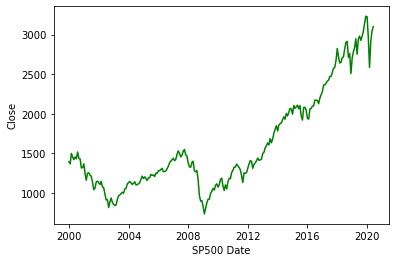

In [61]:
sb.lineplot(data=data, x='SP500 Date', y='Close', color='green')

plt.savefig('SP500LinePlot.png')

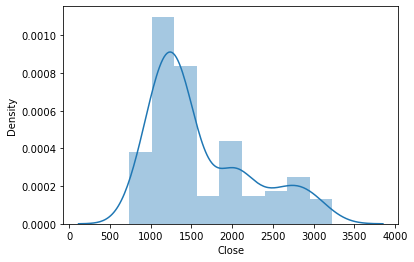

In [62]:
sb.distplot(target)

In [63]:
feat = data.iloc[:, 2:]

feat.head()

,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP,ManufNewOrd,BusTendSurvManuf
0,1473.099976,1387.380005,1.964069e+10,94.1593,0.00000,105.4,130772.0,4.0,101.392898,196344.0,100.16403
1,1478.000000,1350.140015,2.149440e+10,94.1758,87.04694,112.0,131005.0,4.0,101.451927,201360.0,100.00806
2,1444.550049,1325.069946,2.091200e+10,94.4557,173.57820,111.3,131124.0,4.1,101.516102,183911.0,99.81309
3,1552.869995,1346.619995,2.615620e+10,94.7980,241.57833,107.1,131596.0,4.0,101.593821,192130.0,99.62009
4,1527.189941,1339.400024,2.010646e+10,95.4808,17.11449,109.2,131888.0,3.8,101.668810,195044.0,99.43039


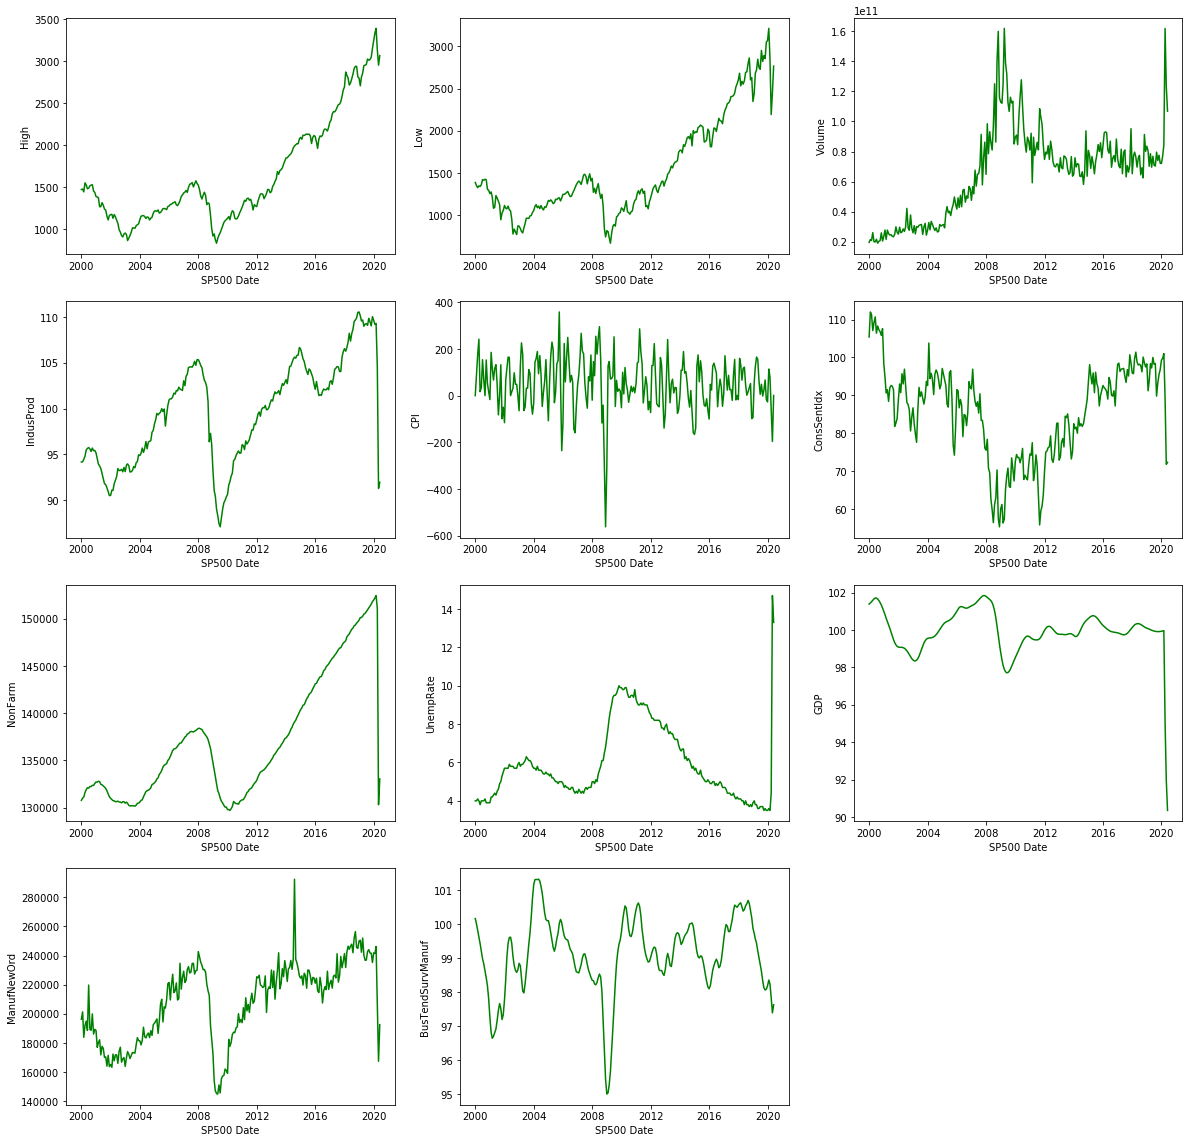

In [64]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for i, feature in enumerate(feat.columns):
    sb.lineplot(data=feat, x=data['SP500 Date'], y=feature, color='green', ax=axes[i//3, i%3])
    
fig.delaxes(axes[3][2])

We can extract some insights from the line graphs above. 

One thing that immediately stands out is that generally they show strong movements in the direction that we would expect them to during crashes, such as the tech crash (2000), credit crunch (2008) and the most recent coronavirus driven crash. For example, industrial production and manufacturer's new orders and sentiment took a hit in the early 2000s, 2008 and 2020. However, new manufacturing orders and manufacturer's sentiment most definitely took the biggest hit in 2008. This makes sense since during that time there was huge panic with regard to the availability of credit and future financing, which a lot of production projects depend on. The early 2000s was arguably more related to overflated expectations and valuations of tech firms rather than a fundamental systematic issue with the economy, and when it comes to 2020, we are still uncertain as to the potential long term effects of the virus on the economic system, which probably explains the relatively weaker declines. 

CPI is particularly interesting. Its movement generally follows the same pattern except for 2008 where it saw a sharp fall. Although it has also fallen this year, the decline has not been anywhere near as drastic as in 2008. There could be many possible explanations for this such as lockdown preventing repricing by a lot of businesses, the fact that the data time period does not span much further from when the coronavirus situation started, online business activity stabilising prices, panic buying having increased demand, purchasing patterns (especially for essentials) remaining stable, or businesses just felt that there was no need to reduce prices in general. 

Interestingly, Total Nonfarm Payrolls, unemployment rate and the GDP seems to have gone through the sharpest movements this year. It seems reasonable to assume that the lockdowns that a lot of the developed world went through played an important part in this. With a lot of businesses, particularly those that are consumer facing, effectively having shut down (temporarily or permanently), common sense would infer that hiring and the values of goods and services will decline.

Consumer sentiment seems to have also fallen sharply this year, suggesting that perhaps they are not confident about the US economy being able to rebound back to normal levels quickly.

Naturally, the high and low variables move with the index. Unfortunately, volume has proven to be an indicator of momentum and the line graph confirms this with volumes being extremely high when the S&P 500 plummeted whilst also increasing even before 2008 when the index was rising. Thus, it would need to be transformed or simply dropped for this study. 

### Feature Scaling

Since the variables differ drastically in scale, we need to consider some form of feature scaling before training our models. The two most common methods of normalisation (between 0 and 1) and standardisation will be considered. Histograms and boxplots will be used to aid our decision.

The histograms show that some of our feature variables have a rough normal distribution, whilst others are quite skewed. Thus the initial view is that standardisation may not be the most suitable transformation technique. However, boxplots show the existence of outliers and very long whiskers in general (a lot of our variables have a large range). When carrying out investment analysis, maintaining interpretabiltiy as much as possible is key, and as mentioned before, we want to maintain the effects of outliers. If we use normalisation, we may lose a lot of interpretability, thus, the decision was made to use standardisation instead.

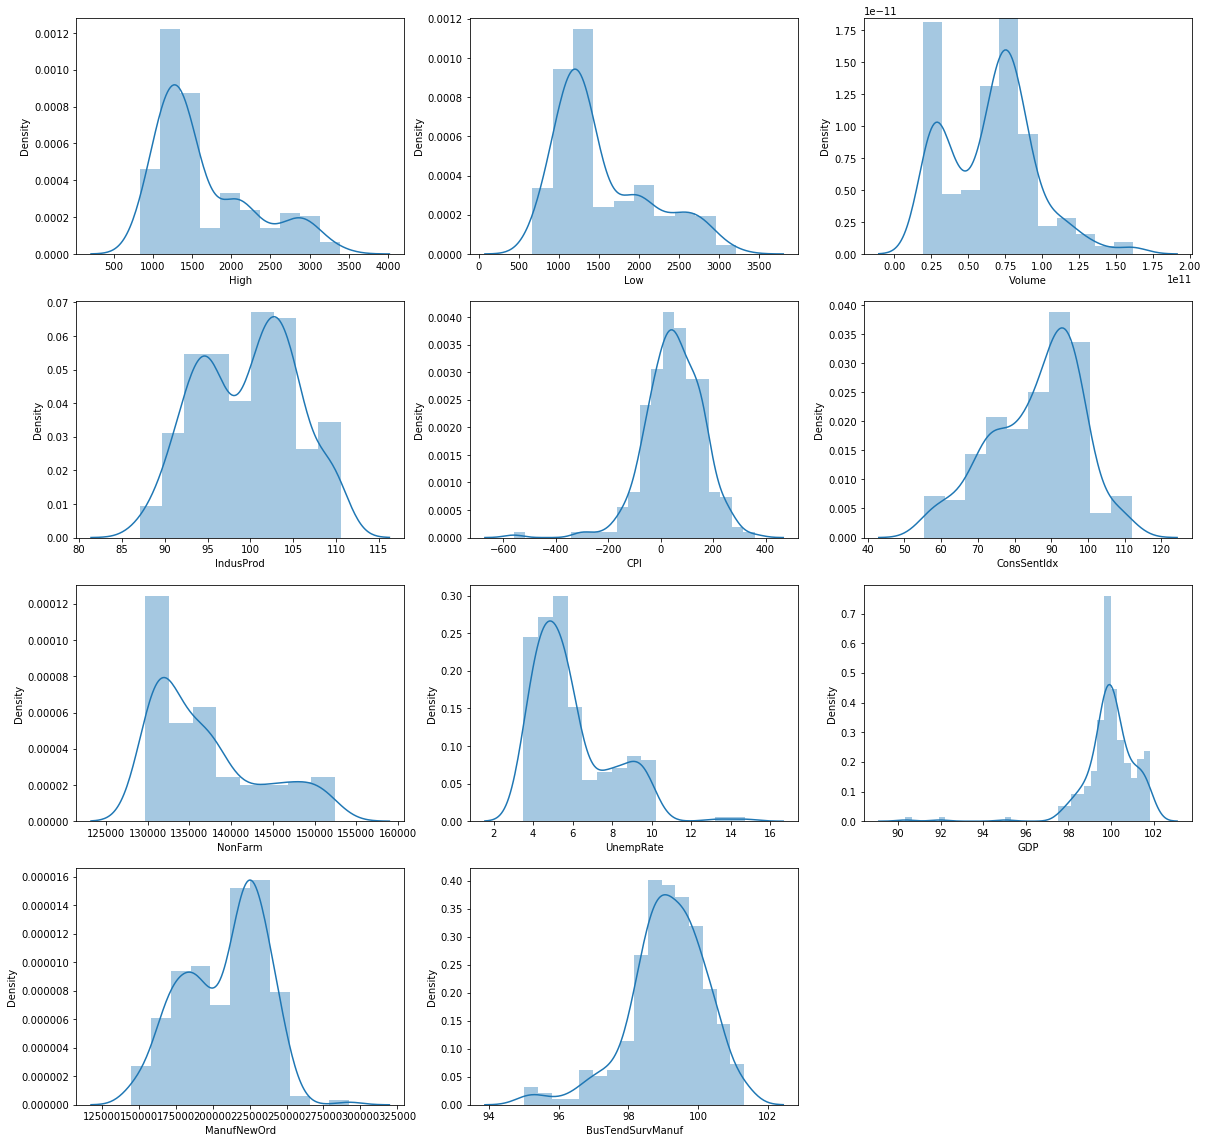

In [65]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for i, feature in enumerate(feat.columns):
    sb.distplot(feat[feature], ax=axes[i//3, i%3])
    
fig.delaxes(axes[3][2])

plt.savefig('FeatureHistograms.png')

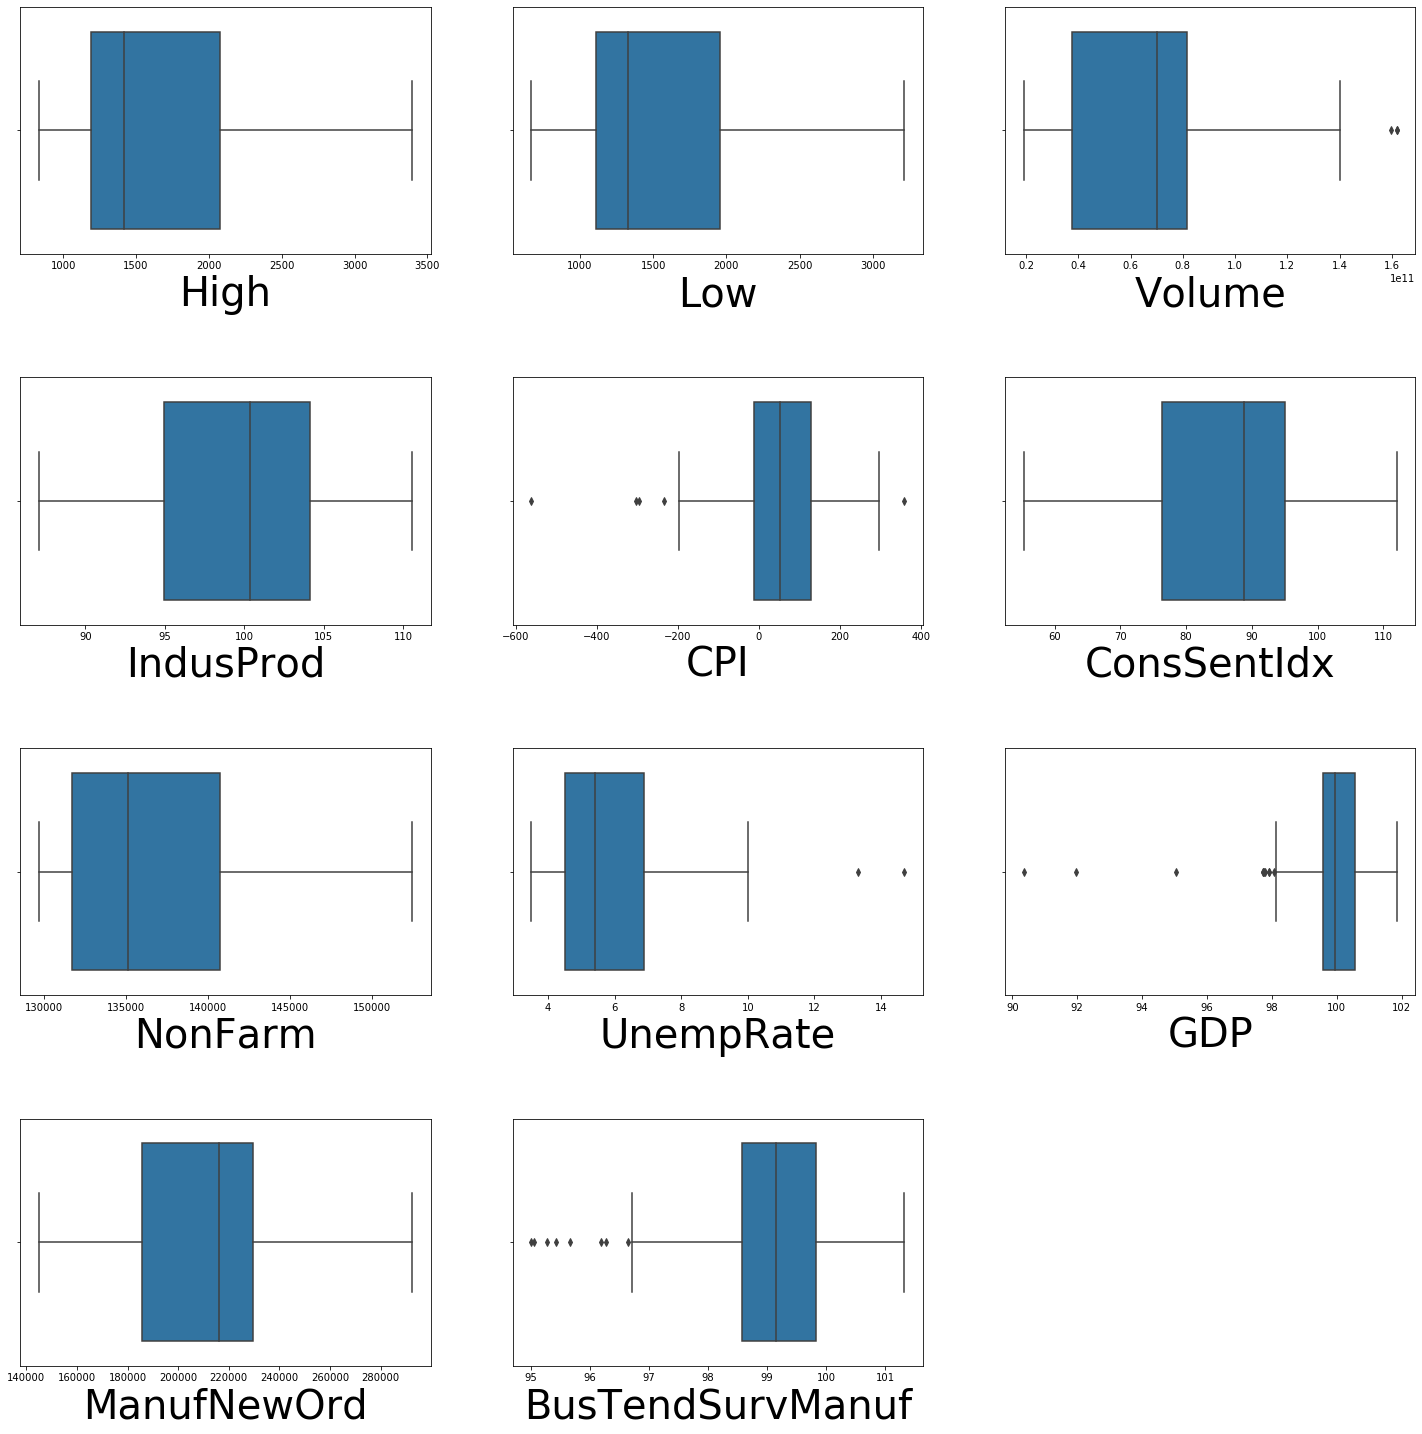

In [66]:
fig, axes = plt.subplots(4, 3, figsize=(25, 25))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

for i, feature in enumerate(feat.columns):
    plot = sb.boxplot(feat[feature], ax=axes[i//3, i%3])
    plot.set_xlabel(feature, fontsize=40)
    plot.tick_params(labelsize=10)

fig.delaxes(axes[3][2])

plt.savefig('FeatureBoxPlots.png')

The scatter plots below suggest that:

S&P 500 Close and High, Low, IndusProd and NonFarm have a fairly strong linear relationship.  
S&P 500 Close and UnempRate and ManufNewOrd seem to have a moderate linear relationship.  
S&P 500 Close and ConsSentIdx looks to have a weak linear relationship.  
S&P 500 Close and Volume, CPI, GDP and BusTendSurv pretty much have no linear relationship.

Based on the general individual relationships between the target and predictor variables, it seems reasonable to
hypothesise that a multiple linear regression model with some of these features will not offer practical 
results.

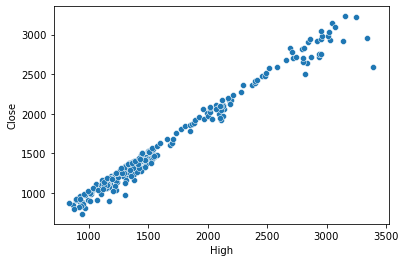

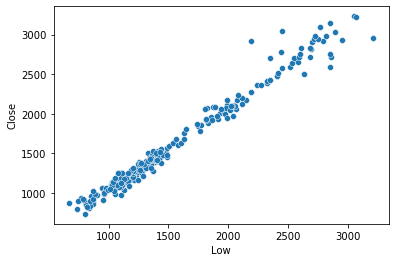

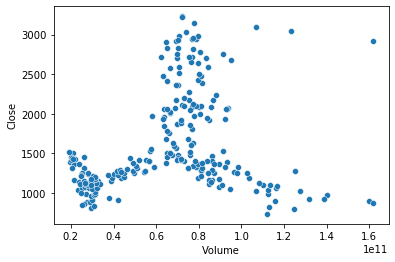

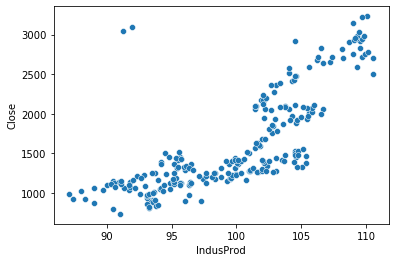

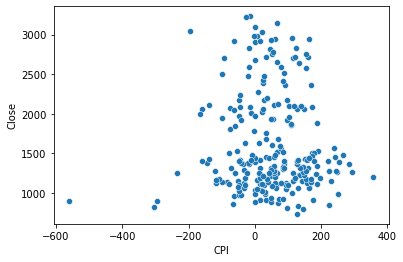

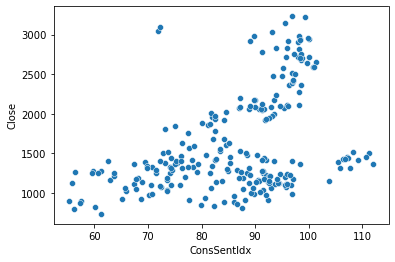

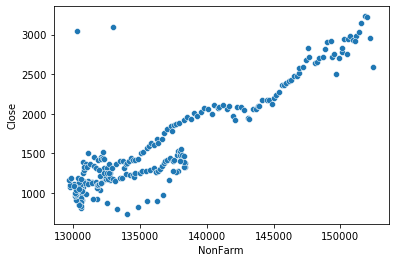

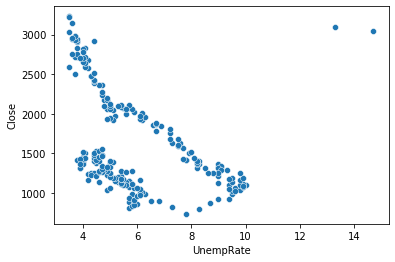

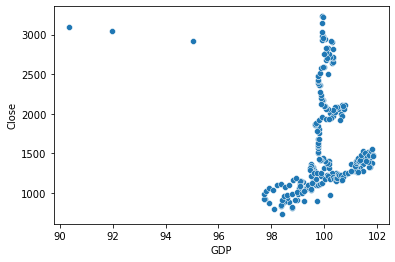

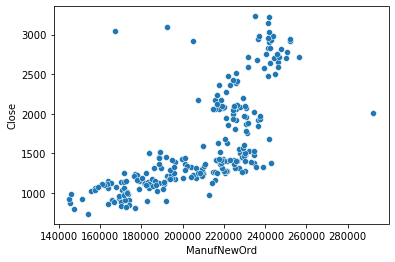

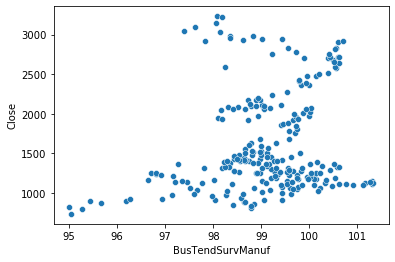

In [67]:
for column in feat:
    sb.scatterplot(x=feat[column], y=data['Close'])
    plt.show()

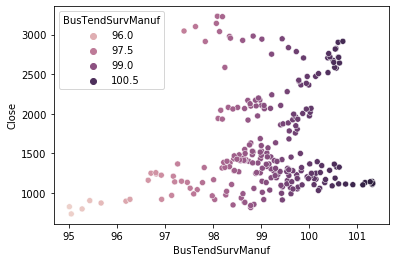

In [68]:
sb.scatterplot(x=feat['BusTendSurvManuf'], y=data['Close'], hue=feat['BusTendSurvManuf'])
plt.savefig('BusTendSurvManufScatterPlot.png')

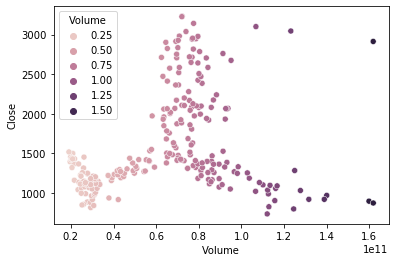

In [69]:
sb.scatterplot(x=feat['Volume'], y=data['Close'], hue=feat['Volume'])
plt.savefig('VolumeScatterPlot.png')

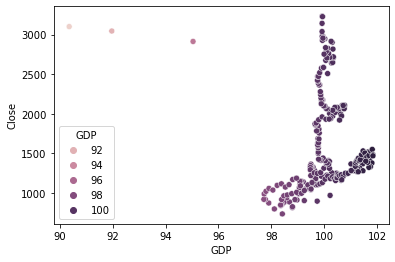

In [70]:
sb.scatterplot(x=feat['GDP'], y=data['Close'], hue=feat['GDP'])
plt.savefig('GDPScatterPlot.png')

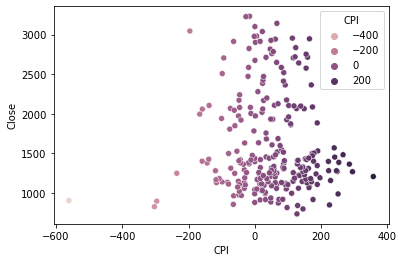

In [71]:
sb.scatterplot(x=feat['CPI'], y=data['Close'], hue=feat['CPI'])
plt.savefig('CPIScatterPlot.png')

In [72]:
data_original.head()

,SP500 Date,Close,High,Low,Volume,IndusProd,CPI,ConsSentIdx,NonFarm,UnempRate,GDP,ManufNewOrd,BusTendSurvManuf
0,1999-12-01,1469.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-01,1394.459961,1473.099976,1387.380005,1.964069e+10,94.1593,0.00000,105.4,130772.0,4.0,101.392898,196344.0,100.16403
2,2000-02-01,1366.420044,1478.000000,1350.140015,2.149440e+10,94.1758,87.04694,112.0,131005.0,4.0,101.451927,201360.0,100.00806
3,2000-03-01,1498.579956,1444.550049,1325.069946,2.091200e+10,94.4557,173.57820,111.3,131124.0,4.1,101.516102,183911.0,99.81309
4,2000-04-01,1452.430054,1552.869995,1346.619995,2.615620e+10,94.7980,241.57833,107.1,131596.0,4.0,101.593821,192130.0,99.62009


### Volume Price Trend (VPT)

In [73]:
# Calculating volume price trend (VPT).
vpt = []

# We use 'data_original' as we need the December 1999 values as well:
for index, row in data_original.iterrows():
    if index == 0:
        continue
    if index == 1:
        close_monthlyPerChange = (row[1] - data_original.iloc[index - 1, 1])/data_original.iloc[index - 1, 1]
        volumePriceTrend = row[4] * close_monthlyPerChange
        vpt.append(volumePriceTrend)
    else:
        close_monthlyPerChange = (row[1] - data_original.iloc[index - 1, 1])/data_original.iloc[index - 1, 1]
        volumePriceTrend = vpt[index - 2] + (row[4] * close_monthlyPerChange)
        vpt.append(volumePriceTrend)
        
vpt = pd.DataFrame(vpt)
vpt.columns = ['VPT']
vpt['Close'] = data['Close']
vpt.head()

,VPT,Close
0,-9.997808e+08,1394.459961
1,-1.431992e+09,1366.420044
2,5.906130e+08,1498.579956
3,-2.148869e+08,1452.430054
4,-6.555210e+08,1420.599976


In [74]:
vpt.tail(10)

,VPT,Close
241,7.204302e+10,2954.219971
242,6.149643e+10,2584.590088
243,8.201994e+10,2912.429932
244,8.759700e+10,3044.310059
245,8.956086e+10,3100.290039
246,9.678156e+10,NaN
247,1.035916e+11,NaN
248,1.002807e+11,NaN
249,1.030843e+11,NaN
250,1.030843e+11,NaN


In [75]:
vpt.drop(vpt.tail(5).index, inplace=True)

vpt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 0 to 245
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VPT     246 non-null    float64
 1   Close   246 non-null    float64
dtypes: float64(2)
memory usage: 5.8 KB


In [76]:
vpt

,VPT,Close
0,-9.997808e+08,1394.459961
1,-1.431992e+09,1366.420044
2,5.906130e+08,1498.579956
3,-2.148869e+08,1452.430054
4,-6.555210e+08,1420.599976
...,...,...
241,7.204302e+10,2954.219971
242,6.149643e+10,2584.590088
243,8.201994e+10,2912.429932
244,8.759700e+10,3044.310059


With a little data derivation, we were able to create a variable that has a much more identifiable relationship with the S&P 500 close.

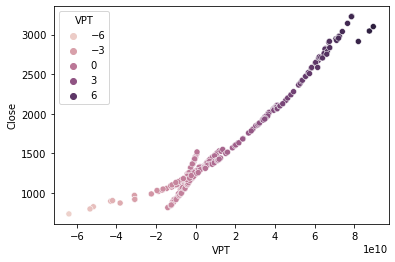

In [77]:
sb.scatterplot(x=vpt['VPT'], y=vpt['Close'], hue=vpt['VPT'])
plt.savefig('VPTScatterPlot.png')

Note! For the graph below, the following blog was used for coding:

https://towardsdatascience.com/trading-toolbox-04-subplots-f6c353278f78 written by Stefano Basurto.

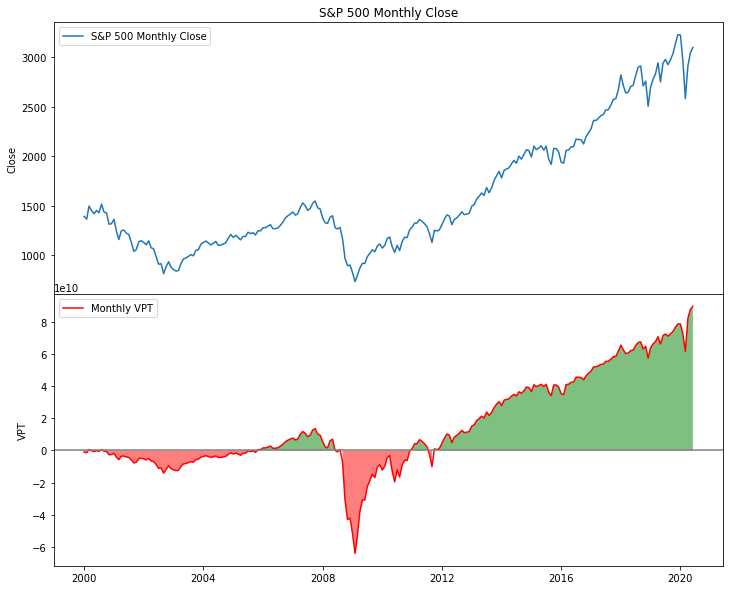

In [78]:
fig = plt.figure(figsize=(12,10))

close_ax = plt.subplot(2, 1, 1)
close_ax.plot(data['SP500 Date'], data['Close'], label='S&P 500 Monthly Close')
close_ax.legend(loc='upper left')

vpt_ax = plt.subplot(2, 1, 2, sharex=close_ax)
vpt_ax.plot(data['SP500 Date'], vpt['VPT'], label='Monthly VPT', color='red')
vpt_ax.legend(loc='upper left')

# We can add titles to each of the subplots:
close_ax.set_title('S&P 500 Monthly Close')

close_ax.get_xaxis().set_visible(False)
fig.subplots_adjust(hspace=0)
vpt_ax.axhline(0, color = (.5, .5, .5))
close_ax.set_ylabel('Close')
vpt_ax.set_ylabel('VPT')
vpt_ax.fill_between(data['SP500 Date'], vpt['VPT'], 0, where=(vpt['VPT'] > 0), facecolor='g', alpha=0.5)
vpt_ax.fill_between(data['SP500 Date'], vpt['VPT'], 0, where=(vpt['VPT'] < 0), facecolor='r', alpha=0.5)

plt.savefig('SP500VPTPlot.png')

## Section Five: Multiple Linear Regression

Before we do any data exploration that is specifically related to the assumptions of the model, let us first note the assumptions of a linear regression model.

Each assumption, if violated, means we may have to take extra steps to improve our data or model:

1. Check for regression residuals being normally distributed.

2. Check for a linear relationship between the dependent and independent variables - already done!

3. Check for residuals being homoscedastic.

4. Check for (and feature select if necessary) multicollinearity, i.e. the independent variables should not be too highly correlated with each other.

5. Check for no autocorrelation of the residuals.

In [79]:
feat_with_drops = feat

# We drop the following variables as they are deemed to be unsuitable for our linear regression models.
del feat_with_drops['Volume']
del feat_with_drops['GDP']
del feat_with_drops['CPI']
del feat_with_drops['BusTendSurvManuf']

feat_with_drops['VPT'] = vpt['VPT']
feat_with_drops.head()

,High,Low,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
0,1473.099976,1387.380005,94.1593,105.4,130772.0,4.0,196344.0,-9.997808e+08
1,1478.000000,1350.140015,94.1758,112.0,131005.0,4.0,201360.0,-1.431992e+09
2,1444.550049,1325.069946,94.4557,111.3,131124.0,4.1,183911.0,5.906130e+08
3,1552.869995,1346.619995,94.7980,107.1,131596.0,4.0,192130.0,-2.148869e+08
4,1527.189941,1339.400024,95.4808,109.2,131888.0,3.8,195044.0,-6.555210e+08


In [80]:
feat_with_drops.tail()

,High,Low,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
241,3337.770020,3214.639893,109.1845,99.8,152212.0,3.6,241417.0,7.204302e+10
242,3393.520020,2855.840088,109.2966,101.0,152463.0,3.5,246195.0,6.149643e+10
243,3136.719971,2191.860107,104.5221,89.1,151090.0,4.4,205020.0,8.201994e+10
244,2954.860107,2447.489990,91.2658,71.8,130303.0,14.7,167502.0,8.759700e+10
245,3068.669922,2766.639893,91.9327,72.3,133028.0,13.3,192605.0,8.956086e+10


In [81]:
feat_with_drops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   High         246 non-null    float64
 1   Low          246 non-null    float64
 2   IndusProd    246 non-null    float64
 3   ConsSentIdx  246 non-null    float64
 4   NonFarm      246 non-null    float64
 5   UnempRate    246 non-null    float64
 6   ManufNewOrd  246 non-null    float64
 7   VPT          246 non-null    float64
dtypes: float64(8)
memory usage: 15.5 KB


### Multicollinearity

,High,Low,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
High,1.000000,0.990806,0.783620,0.431922,0.920824,-0.404390,0.707341,0.960071
Low,0.990806,1.000000,0.801372,0.451226,0.922044,-0.418217,0.732473,0.963841
IndusProd,0.783620,0.801372,1.000000,0.305953,0.868834,-0.528837,0.938772,0.788261
ConsSentIdx,0.431922,0.451226,0.305953,1.000000,0.375022,-0.737862,0.207605,0.446286
NonFarm,0.920824,0.922044,0.868834,0.375022,1.000000,-0.558826,0.760579,0.868924
UnempRate,-0.404390,-0.418217,-0.528837,-0.737862,-0.558826,1.000000,-0.401182,-0.367328
ManufNewOrd,0.707341,0.732473,0.938772,0.207605,0.760579,-0.401182,1.000000,0.726778
VPT,0.960071,0.963841,0.788261,0.446286,0.868924,-0.367328,0.726778,1.000000


[Text(0.5, 0, 'High'),
 Text(1.5, 0, 'Low'),
 Text(2.5, 0, 'IndusProd'),
 Text(3.5, 0, 'ConsSentIdx'),
 Text(4.5, 0, 'NonFarm'),
 Text(5.5, 0, 'UnempRate'),
 Text(6.5, 0, 'ManufNewOrd'),
 Text(7.5, 0, 'VPT')]

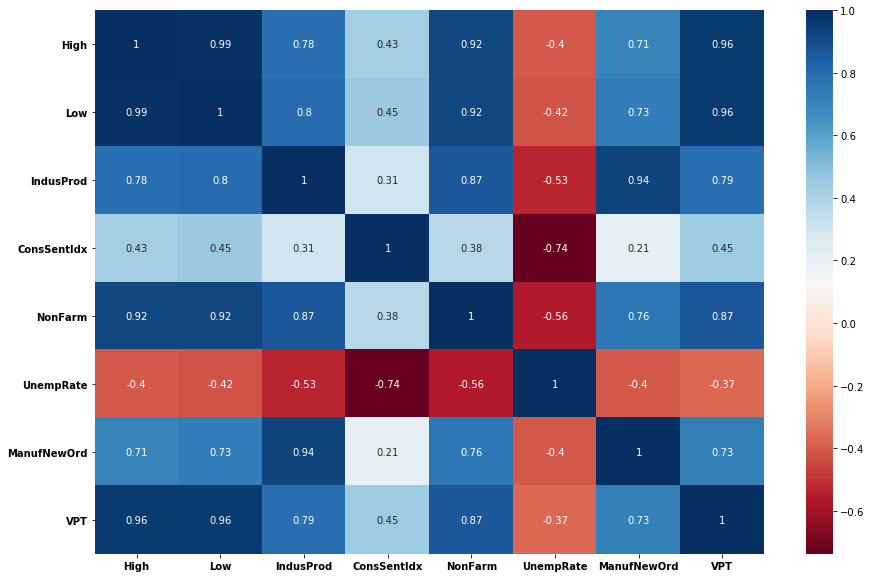

In [82]:
featCorr = feat_with_drops.corr()

# Display the correlation matrix.
display(featCorr)

# Plot the correlation heatmap.
fig, ax = plt.subplots(figsize=(15, 10))
plot = sb.heatmap(featCorr, xticklabels=featCorr.columns, yticklabels=featCorr.columns, cmap='RdBu', annot=True)
plot.set_yticklabels(plot.get_ymajorticklabels(), weight='bold')
plot.set_xticklabels(plot.get_xmajorticklabels(), weight='bold')

Unfortunately, multicollinearity exists between some feature variables.

Examples of particularly strong ones are:

High/Low = 0.99  
High/Nonfarm Payrolls = 0.92  
High/VPT = 0.96  
Industrial Production Index/Manuf New Orders = 0.94

Note! For this section, the following resources were used for coding:

https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0 by Eryk Lewinson.

https://www.datacamp.com/courses/generalized-linear-models-in-python.

Variance inflation factor (VIF) has been chosen to test for the extent of multicollinearity, as it is a very common tool within statistical research. It essentially allows us to quantify and gauge the extent of variance inflation from multicollinearity. In addition, the square root of VIF gives us an idea of how much larger the standard error is, relative to how large it would be if that predictor was uncorrelated with others.

In [83]:
# Use variance inflation factor to remove multicollinear features.
vif = pd.DataFrame()

# We add a constant here as our intercept because the statsmodels version of VIF uses OLS.
# The statsmodels version of OLS does not add an intercept by default unlike sklearn.
featuresForVIF = sm.tools.add_constant(feat_with_drops)

vif['Feature'] = featuresForVIF.columns

featuresForVIF

,const,High,Low,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
0,1.0,1473.099976,1387.380005,94.1593,105.4,130772.0,4.0,196344.0,-9.997808e+08
1,1.0,1478.000000,1350.140015,94.1758,112.0,131005.0,4.0,201360.0,-1.431992e+09
2,1.0,1444.550049,1325.069946,94.4557,111.3,131124.0,4.1,183911.0,5.906130e+08
3,1.0,1552.869995,1346.619995,94.7980,107.1,131596.0,4.0,192130.0,-2.148869e+08
4,1.0,1527.189941,1339.400024,95.4808,109.2,131888.0,3.8,195044.0,-6.555210e+08
...,...,...,...,...,...,...,...,...,...
241,1.0,3337.770020,3214.639893,109.1845,99.8,152212.0,3.6,241417.0,7.204302e+10
242,1.0,3393.520020,2855.840088,109.2966,101.0,152463.0,3.5,246195.0,6.149643e+10
243,1.0,3136.719971,2191.860107,104.5221,89.1,151090.0,4.4,205020.0,8.201994e+10
244,1.0,2954.860107,2447.489990,91.2658,71.8,130303.0,14.7,167502.0,8.759700e+10


In [84]:
print(len(featuresForVIF.columns))
print(featuresForVIF.shape[1])

9
9


In [85]:
# Calculating VIF for each feature: 
vif['VIF'] = pd.Series([variance_inflation_factor(featuresForVIF.values, i) 
                        for i in range(len(featuresForVIF.columns))])

vif

,Feature,VIF
0,const,10342.927860
1,High,65.745904
2,Low,76.176380
3,IndusProd,18.837296
4,ConsSentIdx,5.486959
5,NonFarm,21.825261
6,UnempRate,6.795821
7,ManufNewOrd,11.020368
8,VPT,17.834298


The VIF data above further confirms for us that some of our variables have extremely high multicollinearity. Let us continuously drop variables with the highest VIF (above 5).

In [86]:
feat_with_vif_drops = feat_with_drops.drop(
    ['Low'], 
    axis = 1)

feat_with_vif_drops

,High,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
0,1473.099976,94.1593,105.4,130772.0,4.0,196344.0,-9.997808e+08
1,1478.000000,94.1758,112.0,131005.0,4.0,201360.0,-1.431992e+09
2,1444.550049,94.4557,111.3,131124.0,4.1,183911.0,5.906130e+08
3,1552.869995,94.7980,107.1,131596.0,4.0,192130.0,-2.148869e+08
4,1527.189941,95.4808,109.2,131888.0,3.8,195044.0,-6.555210e+08
...,...,...,...,...,...,...,...
241,3337.770020,109.1845,99.8,152212.0,3.6,241417.0,7.204302e+10
242,3393.520020,109.2966,101.0,152463.0,3.5,246195.0,6.149643e+10
243,3136.719971,104.5221,89.1,151090.0,4.4,205020.0,8.201994e+10
244,2954.860107,91.2658,71.8,130303.0,14.7,167502.0,8.759700e+10


In [87]:
# We now check again for VIF without the dropped features.
vif_drop = pd.DataFrame()

featuresDropForVIF = sm.tools.add_constant(feat_with_vif_drops)

featuresDropForVIF

,const,High,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
0,1.0,1473.099976,94.1593,105.4,130772.0,4.0,196344.0,-9.997808e+08
1,1.0,1478.000000,94.1758,112.0,131005.0,4.0,201360.0,-1.431992e+09
2,1.0,1444.550049,94.4557,111.3,131124.0,4.1,183911.0,5.906130e+08
3,1.0,1552.869995,94.7980,107.1,131596.0,4.0,192130.0,-2.148869e+08
4,1.0,1527.189941,95.4808,109.2,131888.0,3.8,195044.0,-6.555210e+08
...,...,...,...,...,...,...,...,...
241,1.0,3337.770020,109.1845,99.8,152212.0,3.6,241417.0,7.204302e+10
242,1.0,3393.520020,109.2966,101.0,152463.0,3.5,246195.0,6.149643e+10
243,1.0,3136.719971,104.5221,89.1,151090.0,4.4,205020.0,8.201994e+10
244,1.0,2954.860107,91.2658,71.8,130303.0,14.7,167502.0,8.759700e+10


In [88]:
vif_drop['Feature'] = featuresDropForVIF.columns

vif_drop['VIF'] = pd.Series([variance_inflation_factor(featuresDropForVIF.values, i) 
                        for i in range(len(featuresDropForVIF.columns))])

vif_drop

,Feature,VIF
0,const,9599.583618
1,High,26.674030
2,IndusProd,18.672911
3,ConsSentIdx,4.966136
4,NonFarm,20.131902
5,UnempRate,6.468560
6,ManufNewOrd,10.436185
7,VPT,16.964552


In [89]:
# IndusProd and ManufNewOrd still have high VIFs. Let us try dropping IndusProd.
feat_with_vif_drops = feat_with_vif_drops.drop(
    ['High'], 
    axis = 1)

vif_drop = pd.DataFrame()

featuresDropForVIF = sm.tools.add_constant(feat_with_vif_drops)

vif_drop['Feature'] = featuresDropForVIF.columns

vif_drop['VIF'] = pd.Series([variance_inflation_factor(featuresDropForVIF.values, i) 
                        for i in range(len(featuresDropForVIF.columns))])

vif_drop

,Feature,VIF
0,const,7431.788005
1,IndusProd,17.875858
2,ConsSentIdx,4.597315
3,NonFarm,10.519640
4,UnempRate,5.898928
5,ManufNewOrd,10.337515
6,VPT,9.423275


In [90]:
feat_with_vif_drops = feat_with_vif_drops.drop(
    ['IndusProd'], 
    axis = 1)

vif_drop = pd.DataFrame()

featuresDropForVIF = sm.tools.add_constant(feat_with_vif_drops)

vif_drop['Feature'] = featuresDropForVIF.columns

vif_drop['VIF'] = pd.Series([variance_inflation_factor(featuresDropForVIF.values, i) 
                        for i in range(len(featuresDropForVIF.columns))])

vif_drop

,Feature,VIF
0,const,6358.192032
1,ConsSentIdx,4.530872
2,NonFarm,9.243785
3,UnempRate,5.534888
4,ManufNewOrd,2.860430
5,VPT,9.357040


In [91]:
feat_with_vif_drops = feat_with_vif_drops.drop(
    ['VPT'], 
    axis = 1)

# We now check again for VIF without the dropped features.
vif_drop = pd.DataFrame()

# We add a constant here as our intercept because the statsmodels version of VIF uses OLS
featuresDropForVIF = sm.tools.add_constant(feat_with_vif_drops)

vif_drop['Feature'] = featuresDropForVIF.columns

vif_drop['VIF'] = pd.Series([variance_inflation_factor(featuresDropForVIF.values, i) 
                        for i in range(len(featuresDropForVIF.columns))])

vif_drop

,Feature,VIF
0,const,1145.741498
1,ConsSentIdx,2.246314
2,NonFarm,2.907090
3,UnempRate,2.765694
4,ManufNewOrd,2.421676


So we ended up dropping the Low, High, Industrial Production Index and VPT. Naturally, you would expect the Low and High to have an extremely high correlation (confirmed also by our line graphs and correlation matrix) as they are of the movement pattern of the S&P 500 index, thus one would have to be dropped. As we saw from the VPT and Close chart, the VPT also follows the movement of the index fairly closely, so we would assume that we would have to also drop either the High or the VPT (since we dropped the Low first). However, it is not so obvious as to why the VPT still suffered from a high VIF even after dropping the High. Thinking back, it was shown to have a high correlation with Total Nonfarm Payrolls and the Industrial Production Index, but why? Remember, the VPT was derived from the target and it pretty much followed the movement of the Close, and our scatter plots showed a strong relationship between the target and the two aforementioned varibles. Considering this, as the target is a significant component of the VPT, it would make sense that it would suffer from multicollinearity with other variables that also have a strong correlation with the target. It also makes sense that the Industrial Production Index would suffer from multicollinearity with Manufacturer's New Orders alone, since they are both designed to provide insights into the state of production, demand and the state of the overall supply chain. 

In [92]:
feat_with_vif_drops

,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd
0,105.4,130772.0,4.0,196344.0
1,112.0,131005.0,4.0,201360.0
2,111.3,131124.0,4.1,183911.0
3,107.1,131596.0,4.0,192130.0
4,109.2,131888.0,3.8,195044.0
...,...,...,...,...
241,99.8,152212.0,3.6,241417.0
242,101.0,152463.0,3.5,246195.0
243,89.1,151090.0,4.4,205020.0
244,71.8,130303.0,14.7,167502.0


In [93]:
feat_with_vif_drops.describe()

,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd
count,246.000000,246.000000,246.000000,246.000000
mean,85.882520,137016.142276,5.913415,208033.036585
std,12.306739,6506.563662,1.951353,27270.468212
min,55.300000,129698.000000,3.500000,144983.000000
25%,76.400000,131720.000000,4.500000,185696.750000
50%,88.800000,135110.500000,5.400000,216064.500000
75%,95.075000,140771.250000,6.875000,229387.000000
max,112.000000,152463.000000,14.700000,292371.000000


### Splitting The Data Into Training And Testing

In [94]:
# We now need to split the data into training and testing, then standardise the data (test with training parameters).
 
# We will use the traditional 80% and 20%, train/test split:
X_train, X_test, y_train, y_test = train_test_split(feat_with_vif_drops, pd.DataFrame(data.Close), test_size=0.20, random_state=1)

# Standardising the feature variables.
scaler = preprocessing.StandardScaler()

X_train.head()

,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd
169,81.2,137548.0,6.6,222215.0
159,78.6,135680.0,7.5,210095.0
180,93.6,140377.0,5.6,224477.0
147,76.2,133752.0,8.2,219866.0
150,73.2,134007.0,8.2,218827.0


In [95]:
# Notice that the rows for y_train and X_train are the same!
y_train.head()

,Close
169,1859.449951
159,1597.569946
180,1994.989990
147,1397.910034
150,1379.319946


In [96]:
X_test.head()

,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd
67,96.5,134296.0,5.0,194475.0
245,72.3,133028.0,13.3,192605.0
208,97.0,146141.0,4.4,226500.0
222,98.2,148888.0,4.0,247803.0
90,85.3,138069.0,4.6,228619.0


In [97]:
X_train_std = pd.DataFrame(scaler.fit_transform(X_train))
X_train_std.columns = X_train.columns

X_train_std.head()

,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd
0,-0.336723,0.079614,0.355694,0.488728
1,-0.548620,-0.219336,0.835025,0.025751
2,0.673862,0.532358,-0.176896,0.575135
3,-0.744217,-0.527887,1.207838,0.398997
4,-0.988713,-0.487078,1.207838,0.359308


In [98]:
# Transform test features using the parameters of the training set.
X_test_std = pd.DataFrame(scaler.transform(X_test))
X_test_std.columns = X_test.columns

X_test_std.head()

,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd
0,0.910208,-0.440827,-0.496450,-0.570924
1,-1.062062,-0.643754,3.924046,-0.642357
2,0.950958,1.454812,-0.816004,0.652412
3,1.048756,1.894434,-1.029040,1.466175
4,-0.002578,0.162993,-0.709486,0.733357


In [99]:
# Our data is now ready for modelling!

# Linear regression model object:
multiple_regression_model = LinearRegression()

# Train the model using the training set:
multiple_regression_model.fit(X_train_std, y_train)

# Make predictions using the testing set...
predictions = multiple_regression_model.predict(X_test_std)

predictions[:20]

array([[1417.1418648 ],
       [2035.43218143],
       [2485.78033795],
       [2744.63002601],
       [1541.8780551 ],
       [2704.48374625],
       [1205.60550216],
       [1121.5637991 ],
       [2728.0498886 ],
       [1279.36584077],
       [1359.4036496 ],
       [1710.82894987],
       [1390.9108862 ],
       [1043.98761762],
       [1769.09596308],
       [1590.17242324],
       [2117.89846729],
       [1225.88848464],
       [1124.32199472],
       [1397.85193039]])

In [100]:
# Notice that the rows for y_test and X_test are the same!
y_test.head(20)

,Close
67,1220.329956
245,3100.290039
208,2411.800049
222,2816.290039
90,1455.270020
220,2705.270020
58,1173.819946
127,1049.329956
230,2834.399902
4,1420.599976


### Exploration Of Model Results

In [101]:
# Let us now explore our model results.

intercept = multiple_regression_model.intercept_[0]

# Note! The coefficients will be in the order of the features of the training set.
coefficient = multiple_regression_model.coef_

# The intercept term is the value of the dependent variable when all the independent variables are equal to zero. 
print(intercept)

print("The intercept for our model is {:.6}".format(intercept))
print('-'*100)

# For each slope coefficient, it is the estimated change in the dependent variable for a one unit change in that 
# particular independent variable, holding the other independent variables constant.
print(coefficient)

# 'zip' allows us to loop through the tuples of two or more lists and print the data.
for coef in zip(X_train_std.columns, multiple_regression_model.coef_[0]):
    print("The Coefficient for {} is {:.6}".format(coef[0], coef[1]))


1609.0163785918378
The intercept for our model is 1609.02
----------------------------------------------------------------------------------------------------
[[250.88015077 571.75258712 278.89115796  52.07042147]]
The Coefficient for ConsSentIdx is 250.88
The Coefficient for NonFarm is 571.753
The Coefficient for UnempRate is 278.891
The Coefficient for ManufNewOrd is 52.0704


In [102]:
y_test.head()

,Close
67,1220.329956
245,3100.290039
208,2411.800049
222,2816.290039
90,1455.270020


### Heteroscedasticity

What is heteroscedasticity? We get this when our model's residuals do not have constant (or at least close to constant) variance. We can check for this using a scatter plot of Residuals vs Predicted values. Why is heteroscedasticity a problem? If the residuals are not stable, then the model is likely to be giving inconsistent results. Furthermore, if we were to test the model on out of sample data, it probably would not help us to get closer and closer to the true population values. In other words, there is most likely some information that the model has failed to gather/obtain from the sample data. So we basically cannot trust the standard deviation of the residuals. As a result this would give confidence intervals that are too wide/narrow, basically inconsistent.

Note! For this section, the following blog was used for coding:

https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0 by Eryk Lewinson.

In [103]:
y_test_resetIdx = y_test
y_test_resetIdx.reset_index(drop=True, inplace=True)

pred = pd.DataFrame(predictions)
pred.columns = ['Predicted Close']

pred.head()

,Predicted Close
0,1417.141865
1,2035.432181
2,2485.780338
3,2744.630026
4,1541.878055


In [104]:
residuals = y_test_resetIdx.subtract(pred['Predicted Close'], axis=0)

# Just a quick code check.
print(y_test_resetIdx.iloc[0, 0] - pred.iloc[0, 0])

residuals.columns = ['Residuals']
residuals['Predicted'] = pred['Predicted Close']
residuals.head()

-196.81190880159306


,Residuals,Predicted
0,-196.811909,1417.141865
1,1064.857858,2035.432181
2,-73.980289,2485.780338
3,71.660013,2744.630026
4,-86.608035,1541.878055


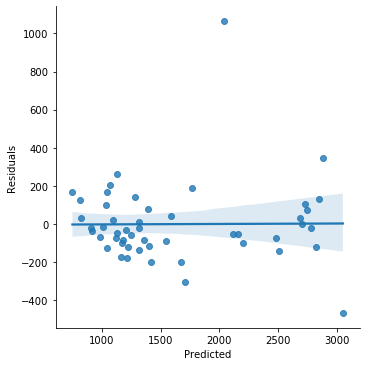

In [105]:
# Unfortunately, the plot below will show that our model has heteroscedastic errors.
sb.lmplot(x='Predicted', y='Residuals', data=residuals)
plt.savefig('MLRHeteroscedasticity.png')

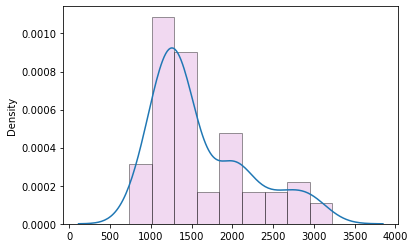

In [106]:
sb.distplot(y_train, hist_kws=dict(color='plum', edgecolor="k", linewidth=1))

Many researchers have suggested using a variance stabilising transformation of the dependent variable. Thus, log and Box Cox transformations of the target variable will be explored to see if they help to mitigate heteroscedasticity.

Close    0.449653
dtype: float64


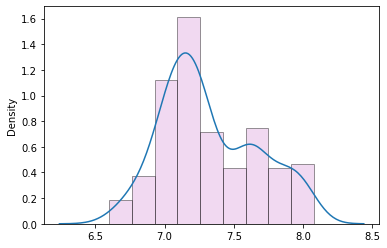

In [107]:
# We are going to try log transforming the target variable.

sb.distplot(np.log(y_train), hist_kws=dict(color='plum', edgecolor="k", linewidth=1))
print(np.log(y_train).skew())
plt.show()

In [108]:
# Linear regression model object:
mregr_log = LinearRegression()

y_train_log = np.log(y_train)

# Train the model using the training set:
mregr_log.fit(X_train_std, y_train_log)

# Make predictions using the testing set...
pred_log = mregr_log.predict(X_test_std)

y_test_log_resetIdx = np.log(y_test)
y_test_log_resetIdx.reset_index(drop=True, inplace=True)

pred_log = pd.DataFrame(pred_log)
pred_log.columns = ['Predicted Close']

pred_log.head()

,Predicted Close
0,7.214219
1,7.549487
2,7.800419
3,7.974307
4,7.316667


In [109]:
y_test_log_resetIdx.head(5)

,Close
0,7.106877
1,8.039251
2,7.788129
3,7.943176
4,7.282947


In [110]:
resid_log = y_test_log_resetIdx.subtract(pred_log['Predicted Close'], axis=0)

print(y_test_log_resetIdx.iloc[0, 0] - pred_log.iloc[0, 0])

resid_log.columns = ['Residuals']
resid_log['Predicted'] = pred_log['Predicted Close']
resid_log.head()

-0.10734264124374082


,Residuals,Predicted
0,-0.107343,7.214219
1,0.489764,7.549487
2,-0.012291,7.800419
3,-0.031132,7.974307
4,-0.033721,7.316667


Log transformation definitely has reduced the issue, but a Box Cox transformation may prove to be a better solution.

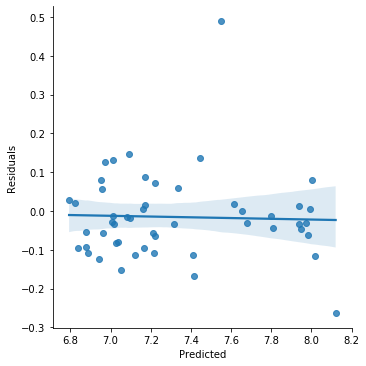

In [111]:
sb.lmplot(x='Predicted', y='Residuals', data=resid_log)

           Close
169  1859.449951
159  1597.569946
180  1994.989990
147  1397.910034
150  1379.319946
..           ...
137  1320.640015
72   1280.079956
140  1131.420044
235  2926.459961
37    841.150024

[196 rows x 1 columns]
0.05527347473518735


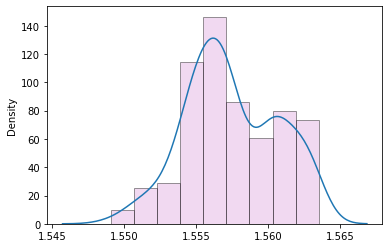

In [112]:
print(y_train)

# Let us now try a Box Cox transformation.
y_train_boxcox, fitted_lambda = sci.stats.boxcox(y_train['Close'])
sb.distplot(y_train_boxcox, hist_kws=dict(color='plum', edgecolor="k", linewidth=1))
print(pd.Series(y_train_boxcox).skew())
plt.show()

In [113]:
y_test_boxcox = sci.stats.boxcox(y_test['Close'], fitted_lambda)

# Linear regression model object:
mregr_boxcox = LinearRegression()

# Train the model using the training set:
mregr_boxcox.fit(X_train_std, y_train_boxcox)

# Make predictions using the training set:
pred_boxcox_trained = mregr_boxcox.predict(X_train_std)

y_train_boxcox_resetIdx = pd.DataFrame(y_train_boxcox)
y_train_boxcox_resetIdx.reset_index(drop=True, inplace=True)

pred_boxcox_trained = pd.DataFrame(pred_boxcox_trained)
pred_boxcox_trained.columns = ['Predicted Close']

# Make predictions using the testing set:
pred_boxcox = mregr_boxcox.predict(X_test_std)

y_test_boxcox_resetIdx = pd.DataFrame(y_test_boxcox)
y_test_boxcox_resetIdx.reset_index(drop=True, inplace=True)

pred_boxcox = pd.DataFrame(pred_boxcox)
pred_boxcox.columns = ['Predicted Close']

pred_boxcox.head()

,Predicted Close
0,1.556501
1,1.559402
2,1.561621
3,1.563364
4,1.557621


In [114]:
y_train_boxcox[:10]

array([1.55963493, 1.55830562, 1.56020888, 1.55702561, 1.55689115,
       1.55396712, 1.55802149, 1.55407992, 1.55591629, 1.56316503])

In [115]:
y_test_boxcox[:10]

array([1.55560657, 1.56327548, 1.56163455, 1.56267842, 1.55742266,
       1.56241745, 1.55517764, 1.55387901, 1.5627194 , 1.5571858 ])

In [116]:
resid_boxcox = y_test_boxcox_resetIdx.subtract(pred_boxcox['Predicted Close'], axis=0)

print(y_test_boxcox_resetIdx.iloc[0, 0] - pred_boxcox.iloc[0, 0])

resid_boxcox.columns = ['Residuals']
resid_boxcox['Predicted'] = pred_boxcox['Predicted Close']
resid_boxcox.head()

-0.0008949170216774327


,Residuals,Predicted
0,-0.000895,1.556501
1,0.003873,1.559402
2,0.000013,1.561621
3,-0.000685,1.563364
4,-0.000198,1.557621


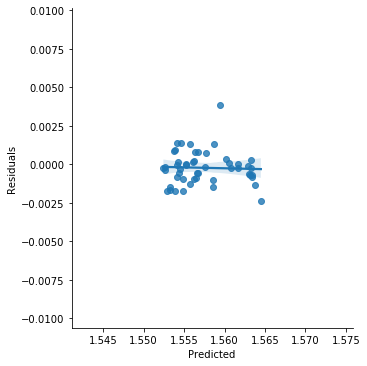

In [117]:
# Box Cox transformation was the most effective in reducing heteroscedasticity.
sb.lmplot(x='Predicted', y='Residuals', data=resid_boxcox)
plt.savefig('MLRBoxCoxHeteroscedasticity.png')

### Autocorrelation (Serial Correlation) Of Residuals 

What is autocorrelation? Autocorrelation is when the correlation between the values of the same variable is based on internal characteristics of the data itself such as lagged time, i.e. a value is related to the previous value. It violates the assumption of instance independence, which underlies most conventional models. Why is this important? Well think about it, if residuals are autocorrelated, then no matter how much data we gather, the heavy effect of the internal characteristic of the residual suggests that the current variables of the model has failed to capture other information that has a strong effect on the target variable. Even worse, autocorrelation of residuals might suggest that our model has an incorrect functional form. For example, a polynomial function might be more appropriate and a linear function completely inappropriate for describing the relationship between our target and feature variables.

Again, there are various statistical diagnostics based methodologies for testing for autocorrelation. For this study, the Durbin-Watson test was chosen due to its relatively simpler interpretability. 

Durbin-Watson of Multiple Linear Regression Model: 1.9481112346384521


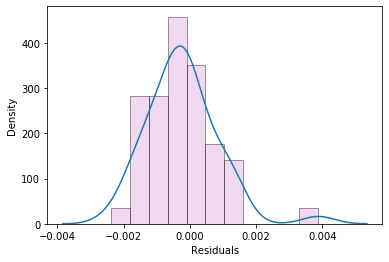

In [118]:
# A Durbin Watson value between 1.5 and 2.5 is generally considered to be normal.
print("Durbin-Watson of Multiple Linear Regression Model: {}".format(durbin_watson(resid_boxcox['Residuals'])))
# We can use the distribution plot below to also check for normally distributed residuals.
sb.distplot(resid_boxcox['Residuals'], hist_kws=dict(color='plum', edgecolor="k", linewidth=1))

In [119]:
# Mean of residuals is also close to 0.
np.mean(resid_boxcox['Residuals'])

-0.00022530499474847864

### Cross-Validation (10 K-fold)

In [120]:
# Cross-validation.
mregr_cv_score = cross_val_score(mregr_boxcox, X_train_std, y_train_boxcox, scoring='r2', cv=10)

print(mregr_cv_score)
print("Multiple Regression Cross-Val Score: {}".format(np.mean(mregr_cv_score)))

[0.80233631 0.89377461 0.91193102 0.87979591 0.9103082  0.85145275
 0.84883612 0.89913321 0.90353701 0.93890134]
Multiple Regression Cross-Val Score: 0.8840006476357095


### Measures Of Error

In [121]:
# Measures of error.

# Calculate the mean squared error.
mregr_boxcox_mse = mean_squared_error(y_test_boxcox, pred_boxcox)

# Calulcate the root mean squared error.
mregr_boxcox_rmse = math.sqrt(mregr_boxcox_mse)

print("MSE {:.6}".format(mregr_boxcox_mse))
print("RMSE {:.6}".format(mregr_boxcox_rmse))

MSE 1.17729e-06
RMSE 0.00108503


### R-squared

Note! The adjusted R-squared formula was found from this website:

https://www.statisticshowto.com/adjusted-r2/

In [122]:
# R-squared.

# Train
mregr_boxcox_trained_rsquared = r2_score(y_train_boxcox, pred_boxcox_trained)
mregr_boxcox_trained_adj_r2 = 1 - ((1 - mregr_boxcox_trained_rsquared) * ((X_train_std.shape[0] - 1) / 
          (X_train_std.shape[0] - X_train_std.shape[1] - 1)))
print('Training')
print(mregr_boxcox_trained_rsquared)
print("R2: {:.2}".format(mregr_boxcox_trained_rsquared))
print("Adj R2: {:.2}".format(mregr_boxcox_trained_adj_r2))

# Test
mregr_boxcox_rsquared = r2_score(y_test_boxcox, pred_boxcox)
mregr_boxcox_adj_r2 = 1 - ((1 - mregr_boxcox_rsquared) * ((X_test_std.shape[0] - 1) / 
          (X_test_std.shape[0] - X_test_std.shape[1] - 1)))
print('-'*100)
print('Testing')
print(mregr_boxcox_rsquared)
print("R2: {:.2}".format(mregr_boxcox_rsquared))
print("Adj R2: {:.2}".format(mregr_boxcox_adj_r2))

Training
0.8972786836113672
R2: 0.9
Adj R2: 0.9
----------------------------------------------------------------------------------------------------
Testing
0.9167310621789684
R2: 0.92
Adj R2: 0.91


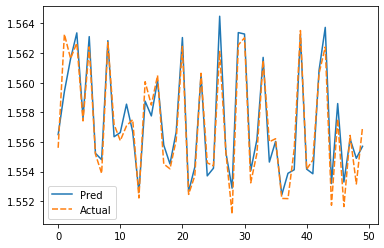

In [123]:
pred_tuned_vs_actual_mregr = pd.DataFrame()
pred_tuned_vs_actual_mregr['Pred'] = pred_boxcox['Predicted Close']
pred_tuned_vs_actual_mregr['Actual'] = y_test_boxcox

sb.lineplot(data=pred_tuned_vs_actual_mregr)

### Hypothesis Testing Of Coefficients With A 95% Confidence Interval

The 95% confidence interval is used because it is one of the most common intervals with many past econometric research studies having used it. We are going to retrain our model using the statsmodels library just so we can use the confidence interval feature.

In [124]:
# Redefine the features:
X_train_std_new = sm.add_constant(X_train_std)
X_test_std_new = sm.add_constant(X_test_std)

X_test_std_new.head()

,const,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd
0,1.0,0.910208,-0.440827,-0.496450,-0.570924
1,1.0,-1.062062,-0.643754,3.924046,-0.642357
2,1.0,0.950958,1.454812,-0.816004,0.652412
3,1.0,1.048756,1.894434,-1.029040,1.466175
4,1.0,-0.002578,0.162993,-0.709486,0.733357


In [125]:
X_train_std_new.head()

,const,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd
0,1.0,-0.336723,0.079614,0.355694,0.488728
1,1.0,-0.548620,-0.219336,0.835025,0.025751
2,1.0,0.673862,0.532358,-0.176896,0.575135
3,1.0,-0.744217,-0.527887,1.207838,0.398997
4,1.0,-0.988713,-0.487078,1.207838,0.359308


In [126]:
# Create a linear regression model:
mregr_boxcox_new = sm.OLS(y_train_boxcox, X_train_std_new)

# Fit the model:
mregrBoxCox = mregr_boxcox_new.fit()

pred_new = mregrBoxCox.predict(X_test_std_new)

# Check our r-squared is the same as the sklearn version:
mregr_boxcox_rsquared_new = r2_score(y_test_boxcox, pred_new)
print(mregr_boxcox_rsquared_new)
print("R2: {:.2}".format(mregr_boxcox_rsquared_new))

mregrBoxCox.conf_int()

0.9167310621789589
R2: 0.92


,0,1
const,1.557302,1.557594
ConsSentIdx,0.001320,0.001753
NonFarm,0.001917,0.002396
UnempRate,0.001217,0.001702
ManufNewOrd,0.000960,0.001386


Since we have set a 95% confidence interval, the alpha is 5% or 0.05 and we are willing to accept a 5% probability of rejecting the null hypothesis, when it is in fact true (type 1 error). Think of it like this, the t-distribution represents our distribution of samples from the population. Then the t-statistic(s) passed which makes up a distribution of 5% of extreme values represents the p-value within which we would reject the null hypothesis. So if p-value <= 0.05 then we reject the null and accept it if p-value > 0.05.

The null hypothesis is that there is no relationship between the dependent and independent variable, with the alternative being that there is.

In [127]:
# Get the p-values!
p_values = mregrBoxCox.pvalues

print(p_values)
print('-'*100)

p_values = np.array(p_values)

for i in p_values:
    print('{:.100f}'.format(i))

const          0.000000e+00
ConsSentIdx    4.924280e-31
NonFarm        2.521676e-42
UnempRate      1.109131e-24
ManufNewOrd    1.124247e-21
dtype: float64
----------------------------------------------------------------------------------------------------
0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0.0000000000000000000000000000004924279984180411193875869023525892473505271248691674683581892099938068
0.0000000000000000000000000000000000000000025216763346628863055643818343049043405150128832508674005059
0.0000000000000000000000011091314985260228837970826474545626214690490212656861286833313455296376459636
0.0000000000000000000011242467208366126864152356796600319944917701464793912316379211058237075349097722


In [128]:
# Note! The r-squared value and some others are slightly different. We will ignore this and only use the coefficient related
# results:
print(mregrBoxCox.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     417.1
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           3.56e-93
Time:                        00:58:17   Log-Likelihood:                 1071.5
No. Observations:                 196   AIC:                            -2133.
Df Residuals:                     191   BIC:                            -2117.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5574    7.4e-05   2.11e+04      

## Section Six: Ridge Regression

We won't re-add the features that were dropped due to poor linearity with the target.

In [129]:
feat.head()

,High,Low,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
0,1473.099976,1387.380005,94.1593,105.4,130772.0,4.0,196344.0,-9.997808e+08
1,1478.000000,1350.140015,94.1758,112.0,131005.0,4.0,201360.0,-1.431992e+09
2,1444.550049,1325.069946,94.4557,111.3,131124.0,4.1,183911.0,5.906130e+08
3,1552.869995,1346.619995,94.7980,107.1,131596.0,4.0,192130.0,-2.148869e+08
4,1527.189941,1339.400024,95.4808,109.2,131888.0,3.8,195044.0,-6.555210e+08


In [130]:
# We will use the traditional 80% and 20%, train/test split:
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(feat, pd.DataFrame(data.Close), test_size=0.20, random_state=1)

# Notice that the rows are the same as when we split the data for the multiple linear regression model.
X_train_ridge.head()

,High,Low,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
169,1850.839966,1770.449951,102.7216,81.2,137548.0,6.6,222215.0,3.124775e+10
159,1570.280029,1501.479980,101.8114,78.6,135680.0,7.5,210095.0,1.973014e+10
180,2093.550049,1972.560059,106.5085,93.6,140377.0,5.6,224477.0,3.661802e+10
147,1419.150024,1340.030029,99.1551,76.2,133752.0,8.2,219866.0,9.552254e+09
150,1363.459961,1266.739990,100.0728,73.2,134007.0,8.2,218827.0,9.334258e+09


In [131]:
y_train_ridge.head()

,Close
169,1859.449951
159,1597.569946
180,1994.989990
147,1397.910034
150,1379.319946


In [132]:
X_test_ridge.head()

,High,Low,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
67,1245.150024,1183.550049,99.6692,96.5,134296.0,5.0,194475.0,-6.547449e+08
245,3068.669922,2766.639893,91.9327,72.3,133028.0,13.3,192605.0,8.956086e+10
208,2398.159912,2328.949951,104.2721,97.0,146141.0,4.4,226500.0,5.342718e+10
222,2791.469971,2691.989990,108.1707,98.2,148888.0,4.0,247803.0,6.517939e+10
90,1540.560059,1484.180054,104.5617,85.3,138069.0,4.6,228619.0,8.565770e+09


In [133]:
y_test_ridge.head()

,Close
67,1220.329956
245,3100.290039
208,2411.800049
222,2816.290039
90,1455.270020


The data seems to have successfully split with the same observations as the multiple linear regression experiment. Thus, for the target we will just re-use the Box Cox transformed versions.

In [134]:
# Standardising the feature variables.
new_scaler = preprocessing.StandardScaler()

X_train_ridge_std = pd.DataFrame(new_scaler.fit_transform(X_train_ridge))
X_train_ridge_std.columns = X_train_ridge.columns

X_train_ridge_std.head()

,High,Low,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
0,0.347934,0.405900,0.539889,-0.336723,0.079614,0.355694,0.488728,0.559878
1,-0.123545,-0.066549,0.370982,-0.548620,-0.219336,0.835025,0.025751,0.157396
2,0.755807,0.760908,1.242630,0.673862,0.532358,-0.176896,0.575135,0.747541
3,-0.377518,-0.350137,-0.121952,-0.744217,-0.527887,1.207838,0.398997,-0.198269
4,-0.471105,-0.478872,0.048347,-0.988713,-0.487078,1.207838,0.359308,-0.205887


In [135]:
X_test_ridge_std = pd.DataFrame(new_scaler.transform(X_test_ridge))
X_test_ridge_std.columns = X_test_ridge.columns

X_test_ridge_std.head()

,High,Low,IndusProd,ConsSentIdx,NonFarm,UnempRate,ManufNewOrd,VPT
0,-0.669924,-0.624996,-0.026549,0.910208,-0.440827,-0.496450,-0.570924,-0.554952
1,2.394490,2.155718,-1.462223,-1.062062,-0.643754,3.924046,-0.642357,2.597624
2,1.267702,1.386911,0.827618,0.950958,1.454812,-0.816004,0.652412,1.334936
3,1.928657,2.024594,1.551087,1.048756,1.894434,-1.029040,1.466175,1.745616
4,-0.173489,-0.096936,0.881359,-0.002578,0.162993,-0.709486,0.733357,-0.232742


In [136]:
y_train_boxcox[:10]

array([1.55963493, 1.55830562, 1.56020888, 1.55702561, 1.55689115,
       1.55396712, 1.55802149, 1.55407992, 1.55591629, 1.56316503])

In [137]:
y_test_boxcox[:10]

array([1.55560657, 1.56327548, 1.56163455, 1.56267842, 1.55742266,
       1.56241745, 1.55517764, 1.55387901, 1.5627194 , 1.5571858 ])

Note! The following resource was used for this section:

https://www.datacamp.com/courses/supervised-learning-with-scikit-learn

[0.9506652615256215, 0.9507172755809478, 0.9507611916435131, 0.9507985417790874, 0.9508304716367577, 0.9508578546277292, 0.9508813683591774, 0.950901546968451, 0.950918817688432, 0.9509335268658485, 0.9509459587838018, 0.9509563494859208, 0.9509648970708859, 0.950971769456965, 0.9509771103076504, 0.950981043603725, 0.9509836772070267, 0.9509851056648919, 0.9509854124368543, 0.9509846716775489]
----------------------------------------------------------------------------------------------------
[0.95098541 0.95098511 0.95098467 0.95098368 0.95098104 0.95097711
 0.95097177 0.9509649  0.95095635 0.95094596 0.95093353 0.95091882
 0.95090155 0.95088137 0.95085785 0.95083047 0.95079854 0.95076119
 0.95071728 0.95066526]
----------------------------------------------------------------------------------------------------
Alpha with highest cv score is: 0.95


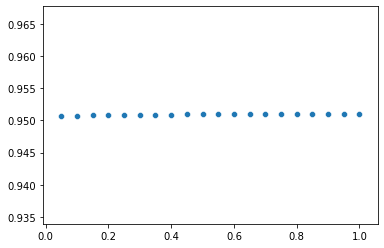

In [138]:
# Setup the array of alphas and lists to store scores
alpha_values = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor
ridge = Ridge()

# Compute scores over range of alphas
for alpha in alpha_values:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train_ridge_std, y_train_boxcox, scoring='r2', cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

print(ridge_scores)
ridge_scores_sorted = np.sort(ridge_scores)[::-1]
print('-'*100)
print(ridge_scores_sorted)
alpha_with_highest_cvscore = ridge_scores.index(ridge_scores_sorted[0])
alpha_with_highest_cvscore = alpha_values[alpha_with_highest_cvscore]
    
print('-'*100)
print("Alpha with highest cv score is: {}".format(alpha_with_highest_cvscore))

sb.scatterplot(x=alpha_values, y=ridge_scores)

In [139]:
# R-squared.

ridge = Ridge(alpha=0.95)

ridge = ridge.fit(X_train_ridge_std, y_train_boxcox)

ridge_cv_score = cross_val_score(ridge, X_train_ridge_std, y_train_boxcox, scoring='r2', cv=10)
print(np.mean(ridge_cv_score))

# First, let us test the model on training data:
pred_ridge_trained = ridge.predict(X_train_ridge_std)

pred_ridge_trained = pd.DataFrame(pred_ridge_trained)
pred_ridge_trained.columns = ['Predicted Close']

# Now on test data:
pred_ridge = ridge.predict(X_test_ridge_std)

pred_ridge = pd.DataFrame(pred_ridge)
pred_ridge.columns = ['Predicted Close']

0.9509854124368543


In [140]:
# R-squared.

# Train:
ridge_rsquared_trained = r2_score(y_train_boxcox, pred_ridge_trained)
ridge_adj_r2_trained = 1 - ((1 - ridge_rsquared_trained) * ((X_train_std.shape[0] - 1) / 
          (X_train_std.shape[0] - X_train_std.shape[1] - 1)))
print('Training Data')
print(ridge_rsquared_trained)
print("R2: {:.2}".format(ridge_rsquared_trained))
print("Adj R2: {:.2}".format(ridge_adj_r2_trained))

print('-'*100)

# Test:
ridge_rsquared = r2_score(y_test_boxcox, pred_ridge)
ridge_adj_r2 = 1 - ((1 - ridge_rsquared) * ((X_test_std.shape[0] - 1) / 
          (X_test_std.shape[0] - X_test_std.shape[1] - 1)))
print('Testing Data')
print(ridge_rsquared)
print("R2: {:.2}".format(ridge_rsquared))
print("Adj R2: {:.2}".format(ridge_adj_r2))

Training Data
0.9602509169941955
R2: 0.96
Adj R2: 0.96
----------------------------------------------------------------------------------------------------
Testing Data
0.9490755103430325
R2: 0.95
Adj R2: 0.94


In [141]:
# Measures of error.

# Calculate the mean squared error.
ridge_mse = mean_squared_error(y_test_boxcox, pred_ridge)

# Calulcate the root mean squared error.
ridge_rmse = math.sqrt(ridge_mse)

print("MSE {:.6}".format(ridge_mse))
print("RMSE {:.6}".format(ridge_rmse))

MSE 7.19992e-07
RMSE 0.000848523


The final version of our ridge regression model will be tuned using grid search, since it is an exhaustive method and because our final search space is not large, we will most likely not experience significant computational expense.

In [142]:
param_grid = {'alpha': np.arange(0.9, 1.01, step=0.01)}
print(param_grid)

ridge_tuned = Ridge()

# Define the grid search
ridge_tuned = GridSearchCV(ridge_tuned, param_grid, scoring='r2', cv=10)

# Fit the grid search
ridge_tuned.fit(X_train_ridge_std, y_train_boxcox)

print('-'*100)

print(ridge_tuned.best_params_)

# Alpha of 0.94 is the best.
print(ridge_tuned.best_score_)

{'alpha': array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])}
----------------------------------------------------------------------------------------------------
{'alpha': 0.9400000000000001}
0.9509854371364066


In [143]:
# Note! The syntax below has been commented out as it gives a huge set of information.
# ridge_tuned.cv_results_

In [144]:
# First, let us test the model on training data:
pred_ridge_tuned_trained = ridge_tuned.predict(X_train_ridge_std)

pred_ridge_tuned_trained = pd.DataFrame(pred_ridge_tuned_trained)
pred_ridge_tuned_trained.columns = ['Predicted Close']

In [145]:
# Now test data:
pred_ridge_tuned = ridge_tuned.predict(X_test_ridge_std)

pred_ridge_tuned = pd.DataFrame(pred_ridge_tuned)
pred_ridge_tuned.columns = ['Predicted Close']

pred_ridge_tuned.head()

,Predicted Close
0,1.555554
1,1.564457
2,1.561391
3,1.563197
4,1.557205


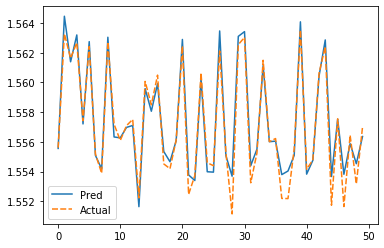

In [146]:
pred_tuned_vs_actual_ridge = pd.DataFrame()
pred_tuned_vs_actual_ridge['Pred'] = pred_ridge_tuned['Predicted Close']
pred_tuned_vs_actual_ridge['Actual'] = y_test_boxcox

sb.lineplot(data=pred_tuned_vs_actual_ridge)

In [147]:
resid_ridge_tuned = y_test_boxcox_resetIdx.subtract(pred_ridge_tuned['Predicted Close'], axis=0)

resid_ridge_tuned.columns = ['Residuals']
resid_ridge_tuned['Predicted'] = pred_ridge_tuned['Predicted Close']
resid_ridge_tuned.head()

,Residuals,Predicted
0,0.000052,1.555554
1,-0.001182,1.564457
2,0.000243,1.561391
3,-0.000519,1.563197
4,0.000218,1.557205


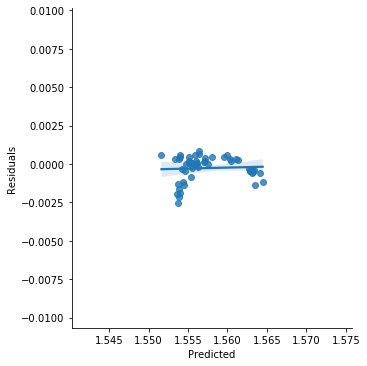

In [148]:
sb.lmplot(x='Predicted', y='Residuals', data=resid_ridge_tuned)
plt.savefig('RidgeBoxCoxHeteroscedasticity.png')

Durbin-Watson of Ridge Regression Model: 1.951854765031373


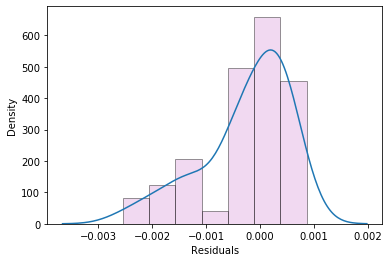

In [149]:
print("Durbin-Watson of Ridge Regression Model: {}".format(durbin_watson(resid_ridge_tuned['Residuals'])))
sb.distplot(resid_ridge_tuned['Residuals'], hist_kws=dict(color='plum', edgecolor="k", linewidth=1))

# The residual distribution is slightly skewed but it is not severe and is close to normal.

In [150]:
# Mean of residuals is also close to 0.
np.mean(resid_ridge_tuned['Residuals'])

-0.00026426949744406513

In [151]:
# R-squared.

ridge_rsquared_tuned_trained = r2_score(y_train_boxcox, pred_ridge_tuned_trained)
ridge_adj_r2_tuned_trained = 1 - ((1 - ridge_rsquared_tuned_trained) * ((X_train_std.shape[0] - 1) / 
          (X_train_std.shape[0] - X_train_std.shape[1] - 1)))
print('Training Data')
print(ridge_rsquared_tuned_trained)
print("R2: {:.2}".format(ridge_rsquared_tuned_trained))
print("Adj R2: {:.2}".format(ridge_adj_r2_tuned_trained))

print('-'*100)

ridge_tuned_rsquared = r2_score(y_test_boxcox, pred_ridge_tuned)
ridge_tuned_adj_r2 = 1 - ((1 - ridge_tuned_rsquared) * ((X_test_std.shape[0] - 1) / 
          (X_test_std.shape[0] - X_test_std.shape[1] - 1)))
print('Testing Data')
print(ridge_tuned_rsquared)
print("R2: {:.2}".format(ridge_tuned_rsquared))
print("Adj R2: {:.2}".format(ridge_tuned_adj_r2))

Training Data
0.9602531320237716
R2: 0.96
Adj R2: 0.96
----------------------------------------------------------------------------------------------------
Testing Data
0.9490638553765164
R2: 0.95
Adj R2: 0.94


In [152]:
# Measures of error.

# Calculate the mean squared error.
ridge_tuned_mse = mean_squared_error(y_test_boxcox, pred_ridge_tuned)

# Calulcate the root mean squared error.
ridge_tuned_rmse = math.sqrt(ridge_tuned_mse)

# We have very low errors for both the original and tuned model.
print("MSE {:.6}".format(ridge_tuned_mse))
print("RMSE {:.6}".format(ridge_tuned_rmse))

MSE 7.20157e-07
RMSE 0.000848621


## Section 7: Concluding Remarks

We have had to transform our dependent variable, so we would need to transform the outputs back in a scenario where the models are used. This adds some inconvenience, but, we have met the assumptions of our models and they have been found to be quite accurate. 

Unfortunately, we were unable to use our chosen technical variables for the multiple linear regression model, which slightly hindered our analysis of using a combination of economic and technical variables, but this creates room for future research. We could also add the monthly open as a potential variable to build, test and compare a purely technical variable based model, as there have been past papers that utilises the high, low and open to predict a particular index's closing value.

There are limitations to our study and a lot of room for future work which will be addressed in the report.